# Model Training

This script is intended to load the clean *Amazon Reviews* training and testing datasets and use them to find the most suitable LSTM model to predict the class (1=negative, 2=positive) corresponding to each review in Amazon.

In [1]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=0ba5db9c148027e3079b0ff03b599704b66dbaff6df38651dc86e39d53bc240d
  Stored in directory: /root/.cache/pip/wheels/3f/73/87/c1e4b2145eb6049bb6c9aaf7ea1e38302b77ca219b6fef5d5c
Successfully built databricks-cli
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 787.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.8/99.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=ac9efc70cee40f58063001ffe7f518354de83fc915ed623f570d7fb2a3e53f40
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Loading the necessary libraries
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import mlflow
import pickle
import itertools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import shutil
from codecarbon import EmissionsTracker
import os

In [4]:
# Init codecarbon
tracker = EmissionsTracker()
tracker.start()

# Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

[codecarbon INFO @ 13:07:59] [setup] RAM Tracking...
[codecarbon INFO @ 13:07:59] [setup] GPU Tracking...
[codecarbon INFO @ 13:07:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:07:59] [setup] CPU Tracking...
[codecarbon WARNING @ 13:07:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:08:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:08:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 13:08:00] >>> Tracker's metadata:
[codecarbon INFO @ 13:08:00]   Platform system: Linux-5.15.65+-x86_64-with-debian-bullseye-sid
[codecarbon INFO @ 13:08:00]   Python version: 3.7.12
[codecarbon INFO @ 13:08:00]   Available RAM : 15.632 GB
[codecarbon INFO @ 13:08:00]   CPU count: 2
[codecarbon INFO @ 13:08:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 13:08:00]   GPU count: 1
[codecarbon INFO @ 13:08:00]   GPU mode

## Data loading

In [5]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
train_dataset = pd.read_csv("../input/taed2-data-preparation/clean_amazon_reviews_train.csv", dtype=dtypes)
train_dataset

,class,review_text
0,2,I got this toy a couple of days ago and I ABSO...
1,2,Though lyrically the overall feel of this reco...
2,2,I have been looking for an anthology of outsta...
3,1,I tried/own both the pink and the orangish col...
4,2,Good coffee pot. Hot coffee. 6-8 cups makes a ...
...,...,...
179995,2,Wow what a helpful book. I was amazed at how a...
179996,2,This cd is pretty good.Why I give it 4.5 stars...
179997,2,I was so happy with everything! The delivery w...
179998,1,Dark shots of limp girls. Wouldn't really know...


In [6]:
# We preset data types in advance, to save memory
dtypes = {
        'class' : 'uint8',
        'review_text' : 'str'
}
test_dataset = pd.read_csv("../input/taed2-data-preparation/clean_amazon_reviews_test.csv", dtype=dtypes)
test_dataset

,class,review_text
0,1,"This is a good read for sure, but the problem ..."
1,2,I got this as a gift for my 10 year old nephew...
2,1,"According to the author, if you work hard, you..."
3,1,"Rambling and pointless, this overhyped tome se..."
4,2,Having read much about the exploits of Octavia...
...,...,...
19995,1,I have had this piece of @#*! for 3 years and ...
19996,1,This metronome is an excellent buy. The sound ...
19997,2,I love her books you get to know al the charac...
19998,1,"Trash,absolute trash. Can't you men stand the ..."


## Preliminary steps

In [7]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [8]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(train_dataset['review_text']))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

class_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
classes = set(train_dataset['class'])
for c in sorted(classes):
    class_vocab.add_token(c)
print("Labels:", len(class_vocab), "classes")

Vocabulary: 138 UTF characters
Labels: 2 classes


In [9]:
#From token or label to index
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in train_dataset['review_text']]
y_train_idx = np.array([class_vocab.token2idx[cl] for cl in train_dataset['class']])
print(y_train_idx[0], x_train_idx[0][:10])

[codecarbon INFO @ 13:08:18] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:08:19] Energy consumed for all GPUs : 0.000109 kWh. All GPUs Power : 26.042 W
[codecarbon INFO @ 13:08:19] Energy consumed for all CPUs : 0.000179 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:08:19] 0.000313 kWh of electricity used since the begining.


1 [48  7 78 86 91  7 91 79 80 90]


A validation procedure will be done to find the optimal parameters for the model. Hence, the training dataset is split (0.85 // 0.15):

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.15, random_state=seed)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

153000 training samples
27000 validation samples


## Starting MLflow

## Model definition

The necessary functions for applying a LSTM model are defined next.

In [11]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [12]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [13]:
class CharRNNClassifier(torch.nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=2,
                 bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        encoded = self.embed(input)
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        output, _ = self.rnn(packed)
        padded_mean, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=0.0)
        padded_max, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        max_layer, _ = padded_max.max(dim=0)
        mean_layer = padded_mean.mean(dim=0)
        output = max_layer + mean_layer
        output = self.h2o(output)
        return output

In [14]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [15]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [16]:
def train(model, optimizer, data, batch_size, token_size, max_norm, log=False):
    model.train()
    total_loss = ncorrect = nsentences = ntokens = niterations = 0
    
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1

    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [17]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [18]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

## Training and validation

In [19]:
# Definition of hyperparameter values
BATCH_SIZE = [32, 64, 128]
TOKEN_SIZE = [100000, 200000]
EPOCHS = [4, 6, 8]
MAX_NORM = [1]
HIDDEN_SIZE = 256
EMBEDDING_SIZE = 32

In [20]:
# Assignation of hyperparameter values
hidden_size = HIDDEN_SIZE
embedding_size = EMBEDDING_SIZE
bidirectional = False
batch_size = BATCH_SIZE
token_size = TOKEN_SIZE
epochs = EPOCHS
max_norm = MAX_NORM

ntokens = len(char_vocab)
nlabels = len(class_vocab)

**Training loop**

In [21]:
run_index = 1
mlflow.set_tracking_uri("https://dagshub.com/jofre444/TAED2.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "jofre444"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "81eeafa3a49e87695a1fd407a849ac42c4c267bc"
mlflow.set_experiment('MODEL TRAINING')

2022/10/14 13:08:21 INFO mlflow.tracking.fluent: Experiment with name 'MODEL TRAINING' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba', creation_time=None, experiment_id='5', last_update_time=None, lifecycle_stage='active', name='MODEL TRAINING', tags={}>

In [22]:
def print_model_information(model, run_id):
    print(mlflow.get_artifact_uri())
    print("runID: %s" % run_id)
    print(model)
    for name, param in model.named_parameters():
        print(f'{name:20} {param.numel()} {list(param.shape)}')
    print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

In [23]:
def configure_plot(fig, ax1, ax2):
    fig.tight_layout(pad=5.0)
    fig.legend(loc='upper center', bbox_to_anchor=(1.05, 0.54), fancybox=True, shadow=True, ncol=1)
    fig.suptitle('Evolution of the model accuracy by epochs', y = 1.005, fontdict = {'size':18})
    ax1.set_title('Training data')
    ax2.set_title('Validation data')
    plt.show()

Training cross-validation model for 4 epochs


[codecarbon INFO @ 13:08:33] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:08:33] Energy consumed for all GPUs : 0.000417 kWh. All GPUs Power : 74.974 W
[codecarbon INFO @ 13:08:33] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:08:33] 0.000820 kWh of electricity used since the begining.
[codecarbon INFO @ 13:08:48] Energy consumed for RAM : 0.000073 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:08:48] Energy consumed for all GPUs : 0.000721 kWh. All GPUs Power : 72.995 W
[codecarbon INFO @ 13:08:48] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:08:48] 0.001326 kWh of electricity used since the begining.
[codecarbon INFO @ 13:09:03] Energy consumed for RAM : 0.000097 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:09:03] Energy consumed for all GPUs : 0.001018 kWh. All GPUs Power : 71.263 W
[codecarbon INFO @ 13:09:03] Energy c

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=80.0% (267s)


[codecarbon INFO @ 13:13:04] Energy consumed for RAM : 0.000488 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:13:04] Energy consumed for all GPUs : 0.006365 kWh. All GPUs Power : 81.61600000000001 W
[codecarbon INFO @ 13:13:04] Energy consumed for all CPUs : 0.003542 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:13:04] 0.010395 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=86.6%


[codecarbon INFO @ 13:13:19] Energy consumed for RAM : 0.000512 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:13:19] Energy consumed for all GPUs : 0.006704 kWh. All GPUs Power : 81.362 W
[codecarbon INFO @ 13:13:19] Energy consumed for all CPUs : 0.003719 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:13:19] 0.010936 kWh of electricity used since the begining.
[codecarbon INFO @ 13:13:34] Energy consumed for RAM : 0.000537 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:13:34] Energy consumed for all GPUs : 0.007013 kWh. All GPUs Power : 73.991 W
[codecarbon INFO @ 13:13:34] Energy consumed for all CPUs : 0.003896 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:13:34] 0.011446 kWh of electricity used since the begining.
[codecarbon INFO @ 13:13:49] Energy consumed for RAM : 0.000561 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:13:49] Energy consumed for all GPUs : 0.007357 kWh. All GPUs Power : 82.852 W
[codecarbon INFO @ 13:13:49] Energy c

| epoch 002 | train accuracy=88.1% (549s)


[codecarbon INFO @ 13:17:49] Energy consumed for RAM : 0.000951 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:17:49] Energy consumed for all GPUs : 0.012679 kWh. All GPUs Power : 87.742 W
[codecarbon INFO @ 13:17:49] Energy consumed for all CPUs : 0.006907 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:17:49] 0.020537 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.6%


[codecarbon INFO @ 13:18:04] Energy consumed for RAM : 0.000976 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:18:04] Energy consumed for all GPUs : 0.013013 kWh. All GPUs Power : 80.373 W
[codecarbon INFO @ 13:18:04] Energy consumed for all CPUs : 0.007084 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:18:04] 0.021074 kWh of electricity used since the begining.
[codecarbon INFO @ 13:18:19] Energy consumed for RAM : 0.001000 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:18:19] Energy consumed for all GPUs : 0.013316 kWh. All GPUs Power : 72.506 W
[codecarbon INFO @ 13:18:19] Energy consumed for all CPUs : 0.007261 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:18:19] 0.021577 kWh of electricity used since the begining.
[codecarbon INFO @ 13:18:34] Energy consumed for RAM : 0.001025 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:18:34] Energy consumed for all GPUs : 0.013613 kWh. All GPUs Power : 71.51 W
[codecarbon INFO @ 13:18:34] Energy co

| epoch 003 | train accuracy=90.4% (832s)


[codecarbon INFO @ 13:22:19] Energy consumed for RAM : 0.001391 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:22:19] Energy consumed for all GPUs : 0.018984 kWh. All GPUs Power : 71.51 W
[codecarbon INFO @ 13:22:19] Energy consumed for all CPUs : 0.010095 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:22:19] 0.030469 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=90.0%


[codecarbon INFO @ 13:22:34] Energy consumed for RAM : 0.001415 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:22:34] Energy consumed for all GPUs : 0.019332 kWh. All GPUs Power : 83.78700000000002 W
[codecarbon INFO @ 13:22:34] Energy consumed for all CPUs : 0.010272 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:22:34] 0.031019 kWh of electricity used since the begining.
[codecarbon INFO @ 13:22:49] Energy consumed for RAM : 0.001440 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:22:49] Energy consumed for all GPUs : 0.019684 kWh. All GPUs Power : 84.529 W
[codecarbon INFO @ 13:22:49] Energy consumed for all CPUs : 0.010449 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:22:49] 0.031573 kWh of electricity used since the begining.
[codecarbon INFO @ 13:23:04] Energy consumed for RAM : 0.001464 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:23:04] Energy consumed for all GPUs : 0.020010 kWh. All GPUs Power : 78.394 W
[codecarbon INFO @ 13:23:0

| epoch 004 | train accuracy=92.0% (1115s)


[codecarbon INFO @ 13:27:04] Energy consumed for RAM : 0.001854 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:27:04] Energy consumed for all GPUs : 0.025194 kWh. All GPUs Power : 82.35100000000001 W
[codecarbon INFO @ 13:27:04] Energy consumed for all CPUs : 0.013459 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:27:04] 0.040508 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.7%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/996319e8cd8e4a0fbfa9f04c2c993804/artifacts
runID: 562f780c90d2432b8dfac9584ee4ec8c
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 13:27:19] Energy consumed for RAM : 0.001879 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:27:19] Energy consumed for all GPUs : 0.025517 kWh. All GPUs Power : 77.69 W
[codecarbon INFO @ 13:27:19] Energy consumed for all CPUs : 0.013637 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:27:19] 0.041033 kWh of electricity used since the begining.
[codecarbon INFO @ 13:27:34] Energy consumed for RAM : 0.001903 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:27:34] Energy consumed for all GPUs : 0.025821 kWh. All GPUs Power : 72.747 W
[codecarbon INFO @ 13:27:34] Energy consumed for all CPUs : 0.013814 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:27:34] 0.041538 kWh of electricity used since the begining.
[codecarbon INFO @ 13:27:49] Energy consumed for RAM : 0.001928 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:27:49] Energy consumed for all GPUs : 0.026155 kWh. All GPUs Power : 80.373 W
[codecarbon INFO @ 13:27:49] Energy co

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=80.0% (266s)


[codecarbon INFO @ 13:31:49] Energy consumed for RAM : 0.002318 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:31:49] Energy consumed for all GPUs : 0.031427 kWh. All GPUs Power : 82.35100000000001 W
[codecarbon INFO @ 13:31:49] Energy consumed for all CPUs : 0.016825 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:31:49] 0.050570 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=85.9%


[codecarbon INFO @ 13:32:04] Energy consumed for RAM : 0.002342 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:32:04] Energy consumed for all GPUs : 0.032048 kWh. All GPUs Power : 149.149 W
[codecarbon INFO @ 13:32:04] Energy consumed for all CPUs : 0.017002 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:32:04] 0.051393 kWh of electricity used since the begining.
[codecarbon INFO @ 13:32:19] Energy consumed for RAM : 0.002367 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:32:19] Energy consumed for all GPUs : 0.032412 kWh. All GPUs Power : 87.495 W
[codecarbon INFO @ 13:32:19] Energy consumed for all CPUs : 0.017179 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:32:19] 0.051958 kWh of electricity used since the begining.
[codecarbon INFO @ 13:32:34] Energy consumed for RAM : 0.002391 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:32:34] Energy consumed for all GPUs : 0.032848 kWh. All GPUs Power : 104.72800000000001 W
[codecarbon INFO @ 13:32

| epoch 002 | train accuracy=87.9% (548s)


[codecarbon INFO @ 13:36:34] Energy consumed for RAM : 0.002782 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:36:34] Energy consumed for all GPUs : 0.038466 kWh. All GPUs Power : 80.08 W
[codecarbon INFO @ 13:36:34] Energy consumed for all CPUs : 0.020189 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:36:34] 0.061437 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=86.2%


[codecarbon INFO @ 13:36:49] Energy consumed for RAM : 0.002806 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:36:49] Energy consumed for all GPUs : 0.038763 kWh. All GPUs Power : 71.47500000000001 W
[codecarbon INFO @ 13:36:49] Energy consumed for all CPUs : 0.020367 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:36:49] 0.061936 kWh of electricity used since the begining.
[codecarbon INFO @ 13:37:04] Energy consumed for RAM : 0.002830 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:37:04] Energy consumed for all GPUs : 0.039250 kWh. All GPUs Power : 116.699 W
[codecarbon INFO @ 13:37:04] Energy consumed for all CPUs : 0.020544 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:37:04] 0.062624 kWh of electricity used since the begining.
[codecarbon INFO @ 13:37:19] Energy consumed for RAM : 0.002855 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:37:19] Energy consumed for all GPUs : 0.039562 kWh. All GPUs Power : 74.926 W
[codecarbon INFO @ 13:37:

| epoch 003 | train accuracy=90.4% (831s)


[codecarbon INFO @ 13:41:19] Energy consumed for RAM : 0.003245 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:41:19] Energy consumed for all GPUs : 0.044997 kWh. All GPUs Power : 81.85600000000001 W
[codecarbon INFO @ 13:41:19] Energy consumed for all CPUs : 0.023554 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:41:19] 0.071796 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=90.1%


[codecarbon INFO @ 13:41:34] Energy consumed for RAM : 0.003270 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:41:34] Energy consumed for all GPUs : 0.045499 kWh. All GPUs Power : 120.646 W
[codecarbon INFO @ 13:41:34] Energy consumed for all CPUs : 0.023731 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:41:34] 0.072500 kWh of electricity used since the begining.
[codecarbon INFO @ 13:41:49] Energy consumed for RAM : 0.003294 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:41:49] Energy consumed for all GPUs : 0.045838 kWh. All GPUs Power : 81.362 W
[codecarbon INFO @ 13:41:49] Energy consumed for all CPUs : 0.023908 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:41:49] 0.073040 kWh of electricity used since the begining.
[codecarbon INFO @ 13:42:04] Energy consumed for RAM : 0.003319 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:42:04] Energy consumed for all GPUs : 0.046179 kWh. All GPUs Power : 81.85600000000001 W
[codecarbon INFO @ 13:42:

| epoch 004 | train accuracy=92.1% (1114s)


[codecarbon INFO @ 13:46:04] Energy consumed for RAM : 0.003709 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:46:04] Energy consumed for all GPUs : 0.051637 kWh. All GPUs Power : 82.35100000000001 W
[codecarbon INFO @ 13:46:04] Energy consumed for all CPUs : 0.026919 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:46:04] 0.082265 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.7%


[codecarbon INFO @ 13:46:19] Energy consumed for RAM : 0.003733 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:46:19] Energy consumed for all GPUs : 0.051955 kWh. All GPUs Power : 76.416 W
[codecarbon INFO @ 13:46:19] Energy consumed for all CPUs : 0.027097 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:46:19] 0.082785 kWh of electricity used since the begining.
[codecarbon INFO @ 13:46:34] Energy consumed for RAM : 0.003758 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:46:34] Energy consumed for all GPUs : 0.052314 kWh. All GPUs Power : 86.259 W
[codecarbon INFO @ 13:46:34] Energy consumed for all CPUs : 0.027274 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:46:34] 0.083346 kWh of electricity used since the begining.
[codecarbon INFO @ 13:46:49] Energy consumed for RAM : 0.003782 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:46:49] Energy consumed for all GPUs : 0.052618 kWh. All GPUs Power : 73.001 W
[codecarbon INFO @ 13:46:49] Energy c

| epoch 005 | train accuracy=93.3% (1396s)


[codecarbon INFO @ 13:50:35] Energy consumed for RAM : 0.004148 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:50:35] Energy consumed for all GPUs : 0.057509 kWh. All GPUs Power : 81.362 W
[codecarbon INFO @ 13:50:35] Energy consumed for all CPUs : 0.030107 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:50:35] 0.091764 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.5%


[codecarbon INFO @ 13:50:50] Energy consumed for RAM : 0.004173 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:50:50] Energy consumed for all GPUs : 0.057828 kWh. All GPUs Power : 76.669 W
[codecarbon INFO @ 13:50:50] Energy consumed for all CPUs : 0.030284 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:50:50] 0.092285 kWh of electricity used since the begining.
[codecarbon INFO @ 13:51:05] Energy consumed for RAM : 0.004197 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:51:05] Energy consumed for all GPUs : 0.058151 kWh. All GPUs Power : 77.405 W
[codecarbon INFO @ 13:51:05] Energy consumed for all CPUs : 0.030461 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:51:05] 0.092809 kWh of electricity used since the begining.
[codecarbon INFO @ 13:51:20] Energy consumed for RAM : 0.004221 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:51:20] Energy consumed for all GPUs : 0.058506 kWh. All GPUs Power : 85.27 W
[codecarbon INFO @ 13:51:20] Energy co

| epoch 006 | train accuracy=94.4% (1679s)


[codecarbon INFO @ 13:55:20] Energy consumed for RAM : 0.004612 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:55:20] Energy consumed for all GPUs : 0.063835 kWh. All GPUs Power : 81.85600000000001 W
[codecarbon INFO @ 13:55:20] Energy consumed for all CPUs : 0.033472 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:55:20] 0.101919 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.4%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/3e7256bcfd1d43ecac8b76dbb201a435/artifacts
runID: cf2cea9e94c34239b2edf6652bd55ba1
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 13:55:35] Energy consumed for RAM : 0.004636 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:55:35] Energy consumed for all GPUs : 0.064142 kWh. All GPUs Power : 73.737 W
[codecarbon INFO @ 13:55:35] Energy consumed for all CPUs : 0.033649 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:55:35] 0.102427 kWh of electricity used since the begining.
[codecarbon INFO @ 13:55:50] Energy consumed for RAM : 0.004661 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:55:50] Energy consumed for all GPUs : 0.064452 kWh. All GPUs Power : 74.443 W
[codecarbon INFO @ 13:55:50] Energy consumed for all CPUs : 0.033826 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 13:55:50] 0.102939 kWh of electricity used since the begining.
[codecarbon INFO @ 13:56:05] Energy consumed for RAM : 0.004685 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 13:56:05] Energy consumed for all GPUs : 0.064757 kWh. All GPUs Power : 73.242 W
[codecarbon INFO @ 13:56:05] Energy c

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=79.8% (266s)


[codecarbon INFO @ 14:00:05] Energy consumed for RAM : 0.005076 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:00:05] Energy consumed for all GPUs : 0.070307 kWh. All GPUs Power : 82.799 W
[codecarbon INFO @ 14:00:05] Energy consumed for all CPUs : 0.036836 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:00:05] 0.112219 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=86.5%


[codecarbon INFO @ 14:00:20] Energy consumed for RAM : 0.005100 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:00:20] Energy consumed for all GPUs : 0.070610 kWh. All GPUs Power : 72.753 W
[codecarbon INFO @ 14:00:20] Energy consumed for all CPUs : 0.037014 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:00:20] 0.112724 kWh of electricity used since the begining.
[codecarbon INFO @ 14:00:35] Energy consumed for RAM : 0.005124 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:00:35] Energy consumed for all GPUs : 0.070925 kWh. All GPUs Power : 75.433 W
[codecarbon INFO @ 14:00:35] Energy consumed for all CPUs : 0.037191 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:00:35] 0.113240 kWh of electricity used since the begining.
[codecarbon INFO @ 14:00:50] Energy consumed for RAM : 0.005149 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:00:50] Energy consumed for all GPUs : 0.071251 kWh. All GPUs Power : 78.394 W
[codecarbon INFO @ 14:00:50] Energy c

| epoch 002 | train accuracy=88.2% (549s)


[codecarbon INFO @ 14:04:50] Energy consumed for RAM : 0.005539 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:04:50] Energy consumed for all GPUs : 0.076644 kWh. All GPUs Power : 82.251 W
[codecarbon INFO @ 14:04:50] Energy consumed for all CPUs : 0.040201 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:04:50] 0.122384 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=89.2%


[codecarbon INFO @ 14:05:05] Energy consumed for RAM : 0.005564 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:05:05] Energy consumed for all GPUs : 0.076974 kWh. All GPUs Power : 79.33200000000001 W
[codecarbon INFO @ 14:05:05] Energy consumed for all CPUs : 0.040379 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:05:05] 0.122917 kWh of electricity used since the begining.
[codecarbon INFO @ 14:05:20] Energy consumed for RAM : 0.005588 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:05:20] Energy consumed for all GPUs : 0.077281 kWh. All GPUs Power : 73.889 W
[codecarbon INFO @ 14:05:20] Energy consumed for all CPUs : 0.040555 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:05:20] 0.123424 kWh of electricity used since the begining.
[codecarbon INFO @ 14:05:35] Energy consumed for RAM : 0.005612 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:05:35] Energy consumed for all GPUs : 0.077625 kWh. All GPUs Power : 82.485 W
[codecarbon INFO @ 14:05:3

| epoch 003 | train accuracy=90.6% (832s)


[codecarbon INFO @ 14:09:35] Energy consumed for RAM : 0.006003 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:09:35] Energy consumed for all GPUs : 0.082916 kWh. All GPUs Power : 81.503 W
[codecarbon INFO @ 14:09:35] Energy consumed for all CPUs : 0.043566 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:09:35] 0.132484 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=88.4%


[codecarbon INFO @ 14:09:50] Energy consumed for RAM : 0.006027 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:09:50] Energy consumed for all GPUs : 0.083230 kWh. All GPUs Power : 75.372 W
[codecarbon INFO @ 14:09:50] Energy consumed for all CPUs : 0.043743 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:09:50] 0.133000 kWh of electricity used since the begining.
[codecarbon INFO @ 14:10:05] Energy consumed for RAM : 0.006052 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:10:05] Energy consumed for all GPUs : 0.083531 kWh. All GPUs Power : 72.406 W
[codecarbon INFO @ 14:10:05] Energy consumed for all CPUs : 0.043920 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:10:05] 0.133503 kWh of electricity used since the begining.
[codecarbon INFO @ 14:10:20] Energy consumed for RAM : 0.006076 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:10:20] Energy consumed for all GPUs : 0.083945 kWh. All GPUs Power : 99.468 W
[codecarbon INFO @ 14:10:20] Energy c

| epoch 004 | train accuracy=92.1% (1118s)


[codecarbon INFO @ 14:14:20] Energy consumed for RAM : 0.006466 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:14:20] Energy consumed for all GPUs : 0.089493 kWh. All GPUs Power : 81.309 W
[codecarbon INFO @ 14:14:20] Energy consumed for all CPUs : 0.046931 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:14:20] 0.142891 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.4%


[codecarbon INFO @ 14:14:35] Energy consumed for RAM : 0.006491 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:14:35] Energy consumed for all GPUs : 0.089819 kWh. All GPUs Power : 78.337 W
[codecarbon INFO @ 14:14:35] Energy consumed for all CPUs : 0.047108 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:14:35] 0.143418 kWh of electricity used since the begining.
[codecarbon INFO @ 14:14:50] Energy consumed for RAM : 0.006515 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:14:50] Energy consumed for all GPUs : 0.090134 kWh. All GPUs Power : 75.57000000000001 W
[codecarbon INFO @ 14:14:50] Energy consumed for all CPUs : 0.047285 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:14:50] 0.143934 kWh of electricity used since the begining.
[codecarbon INFO @ 14:15:05] Energy consumed for RAM : 0.006540 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:15:05] Energy consumed for all GPUs : 0.090462 kWh. All GPUs Power : 78.787 W
[codecarbon INFO @ 14:15:0

| epoch 005 | train accuracy=93.3% (1403s)


[codecarbon INFO @ 14:19:05] Energy consumed for RAM : 0.006930 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:19:05] Energy consumed for all GPUs : 0.095715 kWh. All GPUs Power : 76.62 W
[codecarbon INFO @ 14:19:05] Energy consumed for all CPUs : 0.050296 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:19:05] 0.152941 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.7%


[codecarbon INFO @ 14:19:20] Energy consumed for RAM : 0.006955 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:19:20] Energy consumed for all GPUs : 0.096035 kWh. All GPUs Power : 76.811 W
[codecarbon INFO @ 14:19:20] Energy consumed for all CPUs : 0.050473 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:19:20] 0.153462 kWh of electricity used since the begining.
[codecarbon INFO @ 14:19:35] Energy consumed for RAM : 0.006979 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:19:35] Energy consumed for all GPUs : 0.096416 kWh. All GPUs Power : 91.578 W
[codecarbon INFO @ 14:19:35] Energy consumed for all CPUs : 0.050650 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:19:35] 0.154045 kWh of electricity used since the begining.
[codecarbon INFO @ 14:19:50] Energy consumed for RAM : 0.007003 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:19:50] Energy consumed for all GPUs : 0.096721 kWh. All GPUs Power : 73.153 W
[codecarbon INFO @ 14:19:50] Energy c

| epoch 006 | train accuracy=94.6% (1686s)


[codecarbon INFO @ 14:23:50] Energy consumed for RAM : 0.007394 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:23:50] Energy consumed for all GPUs : 0.102096 kWh. All GPUs Power : 74.883 W
[codecarbon INFO @ 14:23:50] Energy consumed for all CPUs : 0.053660 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:23:50] 0.163150 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.4%


[codecarbon INFO @ 14:24:05] Energy consumed for RAM : 0.007418 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:24:05] Energy consumed for all GPUs : 0.102396 kWh. All GPUs Power : 72.2 W
[codecarbon INFO @ 14:24:05] Energy consumed for all CPUs : 0.053837 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:24:05] 0.163652 kWh of electricity used since the begining.
[codecarbon INFO @ 14:24:20] Energy consumed for RAM : 0.007443 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:24:20] Energy consumed for all GPUs : 0.102741 kWh. All GPUs Power : 82.792 W
[codecarbon INFO @ 14:24:20] Energy consumed for all CPUs : 0.054015 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:24:20] 0.164199 kWh of electricity used since the begining.
[codecarbon INFO @ 14:24:35] Energy consumed for RAM : 0.007467 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:24:35] Energy consumed for all GPUs : 0.103086 kWh. All GPUs Power : 82.938 W
[codecarbon INFO @ 14:24:35] Energy con

| epoch 007 | train accuracy=95.4% (1972s)


[codecarbon INFO @ 14:28:35] Energy consumed for RAM : 0.007857 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:28:35] Energy consumed for all GPUs : 0.108546 kWh. All GPUs Power : 81.997 W
[codecarbon INFO @ 14:28:35] Energy consumed for all CPUs : 0.057025 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:28:35] 0.173428 kWh of electricity used since the begining.


| epoch 007 | valid accuracy=90.7%


[codecarbon INFO @ 14:28:50] Energy consumed for RAM : 0.007882 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:28:50] Energy consumed for all GPUs : 0.108873 kWh. All GPUs Power : 78.546 W
[codecarbon INFO @ 14:28:50] Energy consumed for all CPUs : 0.057202 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:28:50] 0.173957 kWh of electricity used since the begining.
[codecarbon INFO @ 14:29:05] Energy consumed for RAM : 0.007906 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:29:05] Energy consumed for all GPUs : 0.109231 kWh. All GPUs Power : 85.949 W
[codecarbon INFO @ 14:29:05] Energy consumed for all CPUs : 0.057379 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:29:05] 0.174517 kWh of electricity used since the begining.
[codecarbon INFO @ 14:29:20] Energy consumed for RAM : 0.007931 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:29:20] Energy consumed for all GPUs : 0.109568 kWh. All GPUs Power : 80.769 W
[codecarbon INFO @ 14:29:20] Energy c

| epoch 008 | train accuracy=96.0% (2256s)


[codecarbon INFO @ 14:33:20] Energy consumed for RAM : 0.008321 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:33:20] Energy consumed for all GPUs : 0.115007 kWh. All GPUs Power : 81.757 W
[codecarbon INFO @ 14:33:20] Energy consumed for all CPUs : 0.060389 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:33:20] 0.183717 kWh of electricity used since the begining.


| epoch 008 | valid accuracy=90.4%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/bd6ea222159d4c6cb8867a0b4bbeb36f/artifacts
runID: 947b9a9866de46b9b30b750eadb9dc87
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 4 epochs


[codecarbon INFO @ 14:33:35] Energy consumed for RAM : 0.008345 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:33:35] Energy consumed for all GPUs : 0.115365 kWh. All GPUs Power : 86.005 W
[codecarbon INFO @ 14:33:35] Energy consumed for all CPUs : 0.060566 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:33:35] 0.184277 kWh of electricity used since the begining.
[codecarbon INFO @ 14:33:50] Energy consumed for RAM : 0.008370 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:33:50] Energy consumed for all GPUs : 0.115674 kWh. All GPUs Power : 74.383 W
[codecarbon INFO @ 14:33:50] Energy consumed for all CPUs : 0.060743 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:33:50] 0.184788 kWh of electricity used since the begining.
[codecarbon INFO @ 14:34:05] Energy consumed for RAM : 0.008394 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:34:05] Energy consumed for all GPUs : 0.115983 kWh. All GPUs Power : 74.10000000000001 W
[codecarbon INFO @ 14:34:0

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=79.8% (267s)


[codecarbon INFO @ 14:38:06] Energy consumed for RAM : 0.008785 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:38:06] Energy consumed for all GPUs : 0.121470 kWh. All GPUs Power : 78.629 W
[codecarbon INFO @ 14:38:06] Energy consumed for all CPUs : 0.063754 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:38:06] 0.194009 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=84.2%


[codecarbon INFO @ 14:38:21] Energy consumed for RAM : 0.008809 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:38:21] Energy consumed for all GPUs : 0.122069 kWh. All GPUs Power : 143.969 W
[codecarbon INFO @ 14:38:21] Energy consumed for all CPUs : 0.063931 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:38:21] 0.194809 kWh of electricity used since the begining.
[codecarbon INFO @ 14:38:36] Energy consumed for RAM : 0.008834 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:38:36] Energy consumed for all GPUs : 0.122401 kWh. All GPUs Power : 79.729 W
[codecarbon INFO @ 14:38:36] Energy consumed for all CPUs : 0.064108 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:38:36] 0.195343 kWh of electricity used since the begining.
[codecarbon INFO @ 14:38:51] Energy consumed for RAM : 0.008858 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:38:51] Energy consumed for all GPUs : 0.122715 kWh. All GPUs Power : 75.33500000000001 W
[codecarbon INFO @ 14:38:

| epoch 002 | train accuracy=88.2% (550s)


[codecarbon INFO @ 14:42:36] Energy consumed for RAM : 0.009224 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:42:36] Energy consumed for all GPUs : 0.127775 kWh. All GPUs Power : 81.45700000000002 W
[codecarbon INFO @ 14:42:36] Energy consumed for all CPUs : 0.066941 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:42:36] 0.203940 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=89.3%


[codecarbon INFO @ 14:42:51] Energy consumed for RAM : 0.009248 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:42:51] Energy consumed for all GPUs : 0.128153 kWh. All GPUs Power : 90.896 W
[codecarbon INFO @ 14:42:51] Energy consumed for all CPUs : 0.067118 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:42:51] 0.204520 kWh of electricity used since the begining.
[codecarbon INFO @ 14:43:06] Energy consumed for RAM : 0.009273 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:43:06] Energy consumed for all GPUs : 0.128461 kWh. All GPUs Power : 73.85300000000002 W
[codecarbon INFO @ 14:43:06] Energy consumed for all CPUs : 0.067296 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:43:06] 0.205029 kWh of electricity used since the begining.
[codecarbon INFO @ 14:43:21] Energy consumed for RAM : 0.009297 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:43:21] Energy consumed for all GPUs : 0.128764 kWh. All GPUs Power : 72.653 W
[codecarbon INFO @ 14:43:2

| epoch 003 | train accuracy=90.6% (835s)


[codecarbon INFO @ 14:47:21] Energy consumed for RAM : 0.009688 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:47:21] Energy consumed for all GPUs : 0.134149 kWh. All GPUs Power : 81.062 W
[codecarbon INFO @ 14:47:21] Energy consumed for all CPUs : 0.070306 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:47:21] 0.214142 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.8%


[codecarbon INFO @ 14:47:36] Energy consumed for RAM : 0.009712 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:47:36] Energy consumed for all GPUs : 0.134449 kWh. All GPUs Power : 72.159 W
[codecarbon INFO @ 14:47:36] Energy consumed for all CPUs : 0.070483 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:47:36] 0.214644 kWh of electricity used since the begining.
[codecarbon INFO @ 14:47:51] Energy consumed for RAM : 0.009736 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:47:51] Energy consumed for all GPUs : 0.134770 kWh. All GPUs Power : 77.05800000000002 W
[codecarbon INFO @ 14:47:51] Energy consumed for all CPUs : 0.070660 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:47:51] 0.215167 kWh of electricity used since the begining.
[codecarbon INFO @ 14:48:06] Energy consumed for RAM : 0.009761 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:48:06] Energy consumed for all GPUs : 0.135081 kWh. All GPUs Power : 74.59400000000001 W
[codecarbon INF

| epoch 004 | train accuracy=92.1% (1119s)


[codecarbon INFO @ 14:52:06] Energy consumed for RAM : 0.010151 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:52:06] Energy consumed for all GPUs : 0.140506 kWh. All GPUs Power : 81.556 W
[codecarbon INFO @ 14:52:06] Energy consumed for all CPUs : 0.073671 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:52:06] 0.224328 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=89.8%


[codecarbon INFO @ 14:52:21] Energy consumed for RAM : 0.010176 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:52:21] Energy consumed for all GPUs : 0.140679 kWh. All GPUs Power : 41.593 W
[codecarbon INFO @ 14:52:21] Energy consumed for all CPUs : 0.073848 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:52:21] 0.224703 kWh of electricity used since the begining.


mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/13af111c1d904f28bad5c8403417f3ea/artifacts
runID: 848aaa4240d14f73b9f59bfa72cdc160
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 14:52:36] Energy consumed for RAM : 0.010200 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:52:36] Energy consumed for all GPUs : 0.141008 kWh. All GPUs Power : 79.04 W
[codecarbon INFO @ 14:52:36] Energy consumed for all CPUs : 0.074025 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:52:36] 0.225234 kWh of electricity used since the begining.
[codecarbon INFO @ 14:52:51] Energy consumed for RAM : 0.010225 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:52:51] Energy consumed for all GPUs : 0.141327 kWh. All GPUs Power : 76.607 W
[codecarbon INFO @ 14:52:51] Energy consumed for all CPUs : 0.074202 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:52:51] 0.225754 kWh of electricity used since the begining.
[codecarbon INFO @ 14:53:06] Energy consumed for RAM : 0.010249 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:53:06] Energy consumed for all GPUs : 0.141633 kWh. All GPUs Power : 73.389 W
[codecarbon INFO @ 14:53:06] Energy co

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=80.1% (267s)


[codecarbon INFO @ 14:56:51] Energy consumed for RAM : 0.010615 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:56:51] Energy consumed for all GPUs : 0.146845 kWh. All GPUs Power : 81.95100000000001 W
[codecarbon INFO @ 14:56:51] Energy consumed for all CPUs : 0.077036 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:56:51] 0.234495 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=86.4%


[codecarbon INFO @ 14:57:06] Energy consumed for RAM : 0.010639 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:57:06] Energy consumed for all GPUs : 0.147295 kWh. All GPUs Power : 107.99300000000001 W
[codecarbon INFO @ 14:57:06] Energy consumed for all CPUs : 0.077213 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:57:06] 0.235147 kWh of electricity used since the begining.
[codecarbon INFO @ 14:57:21] Energy consumed for RAM : 0.010664 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:57:21] Energy consumed for all GPUs : 0.147592 kWh. All GPUs Power : 71.343 W
[codecarbon INFO @ 14:57:21] Energy consumed for all CPUs : 0.077390 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 14:57:21] 0.235646 kWh of electricity used since the begining.
[codecarbon INFO @ 14:57:36] Energy consumed for RAM : 0.010688 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 14:57:36] Energy consumed for all GPUs : 0.148001 kWh. All GPUs Power : 98.179 W
[codecarbon INFO @ 14:57:

| epoch 002 | train accuracy=88.0% (552s)


[codecarbon INFO @ 15:01:36] Energy consumed for RAM : 0.011079 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:01:36] Energy consumed for all GPUs : 0.153592 kWh. All GPUs Power : 78.084 W
[codecarbon INFO @ 15:01:36] Energy consumed for all CPUs : 0.080400 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:01:36] 0.245071 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.9%


[codecarbon INFO @ 15:01:51] Energy consumed for RAM : 0.011103 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:01:51] Energy consumed for all GPUs : 0.153938 kWh. All GPUs Power : 82.985 W
[codecarbon INFO @ 15:01:51] Energy consumed for all CPUs : 0.080577 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:01:51] 0.245618 kWh of electricity used since the begining.
[codecarbon INFO @ 15:02:06] Energy consumed for RAM : 0.011127 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:02:06] Energy consumed for all GPUs : 0.154244 kWh. All GPUs Power : 73.648 W
[codecarbon INFO @ 15:02:06] Energy consumed for all CPUs : 0.080754 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:02:06] 0.246126 kWh of electricity used since the begining.
[codecarbon INFO @ 15:02:21] Energy consumed for RAM : 0.011152 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:02:21] Energy consumed for all GPUs : 0.154795 kWh. All GPUs Power : 132.317 W
[codecarbon INFO @ 15:02:21] Energy 

| epoch 003 | train accuracy=90.4% (836s)


[codecarbon INFO @ 15:06:21] Energy consumed for RAM : 0.011542 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:06:21] Energy consumed for all GPUs : 0.160301 kWh. All GPUs Power : 79.82600000000001 W
[codecarbon INFO @ 15:06:21] Energy consumed for all CPUs : 0.083765 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:06:21] 0.255609 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.2%


[codecarbon INFO @ 15:06:36] Energy consumed for RAM : 0.011567 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:06:36] Energy consumed for all GPUs : 0.160613 kWh. All GPUs Power : 74.83500000000001 W
[codecarbon INFO @ 15:06:36] Energy consumed for all CPUs : 0.083942 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:06:36] 0.256122 kWh of electricity used since the begining.
[codecarbon INFO @ 15:06:51] Energy consumed for RAM : 0.011591 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:06:51] Energy consumed for all GPUs : 0.160937 kWh. All GPUs Power : 77.849 W
[codecarbon INFO @ 15:06:51] Energy consumed for all CPUs : 0.084120 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:06:51] 0.256647 kWh of electricity used since the begining.
[codecarbon INFO @ 15:07:06] Energy consumed for RAM : 0.011615 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:07:06] Energy consumed for all GPUs : 0.161295 kWh. All GPUs Power : 85.85200000000002 W
[codecarbon INF

| epoch 004 | train accuracy=92.0% (1118s)


[codecarbon INFO @ 15:11:06] Energy consumed for RAM : 0.012006 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:11:06] Energy consumed for all GPUs : 0.166564 kWh. All GPUs Power : 80.327 W
[codecarbon INFO @ 15:11:06] Energy consumed for all CPUs : 0.087130 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:11:06] 0.265699 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.4%


[codecarbon INFO @ 15:11:21] Energy consumed for RAM : 0.012030 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:11:21] Energy consumed for all GPUs : 0.166932 kWh. All GPUs Power : 88.419 W
[codecarbon INFO @ 15:11:21] Energy consumed for all CPUs : 0.087307 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:11:21] 0.266268 kWh of electricity used since the begining.
[codecarbon INFO @ 15:11:36] Energy consumed for RAM : 0.012055 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:11:36] Energy consumed for all GPUs : 0.167287 kWh. All GPUs Power : 85.27 W
[codecarbon INFO @ 15:11:36] Energy consumed for all CPUs : 0.087484 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:11:36] 0.266825 kWh of electricity used since the begining.
[codecarbon INFO @ 15:11:51] Energy consumed for RAM : 0.012079 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:11:51] Energy consumed for all GPUs : 0.167599 kWh. All GPUs Power : 75.124 W
[codecarbon INFO @ 15:11:51] Energy co

| epoch 005 | train accuracy=93.3% (1402s)


[codecarbon INFO @ 15:15:51] Energy consumed for RAM : 0.012469 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:15:51] Energy consumed for all GPUs : 0.172846 kWh. All GPUs Power : 67.22200000000001 W
[codecarbon INFO @ 15:15:51] Energy consumed for all CPUs : 0.090495 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:15:51] 0.275810 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.6%


[codecarbon INFO @ 15:16:06] Energy consumed for RAM : 0.012494 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:16:06] Energy consumed for all GPUs : 0.173149 kWh. All GPUs Power : 72.906 W
[codecarbon INFO @ 15:16:06] Energy consumed for all CPUs : 0.090672 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:16:06] 0.276315 kWh of electricity used since the begining.
[codecarbon INFO @ 15:16:21] Energy consumed for RAM : 0.012518 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:16:21] Energy consumed for all GPUs : 0.173461 kWh. All GPUs Power : 74.82900000000001 W
[codecarbon INFO @ 15:16:21] Energy consumed for all CPUs : 0.090849 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:16:21] 0.276828 kWh of electricity used since the begining.
[codecarbon INFO @ 15:16:36] Energy consumed for RAM : 0.012543 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:16:36] Energy consumed for all GPUs : 0.173833 kWh. All GPUs Power : 89.35600000000001 W
[codecarbon INF

| epoch 006 | train accuracy=94.3% (1687s)


[codecarbon INFO @ 15:20:36] Energy consumed for RAM : 0.012933 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:20:36] Energy consumed for all GPUs : 0.179073 kWh. All GPUs Power : 74.383 W
[codecarbon INFO @ 15:20:36] Energy consumed for all CPUs : 0.093859 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:20:36] 0.285865 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.0%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/d9daf3e3b83f44bca5e83c5a78421cd8/artifacts
runID: fb6aff45ac584436aa2886a4571b083f
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 15:20:51] Energy consumed for RAM : 0.012957 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:20:51] Energy consumed for all GPUs : 0.179381 kWh. All GPUs Power : 73.889 W
[codecarbon INFO @ 15:20:51] Energy consumed for all CPUs : 0.094036 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:20:51] 0.286374 kWh of electricity used since the begining.
[codecarbon INFO @ 15:21:06] Energy consumed for RAM : 0.012982 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:21:06] Energy consumed for all GPUs : 0.179654 kWh. All GPUs Power : 65.734 W
[codecarbon INFO @ 15:21:06] Energy consumed for all CPUs : 0.094213 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:21:06] 0.286850 kWh of electricity used since the begining.
[codecarbon INFO @ 15:21:21] Energy consumed for RAM : 0.013006 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:21:21] Energy consumed for all GPUs : 0.179931 kWh. All GPUs Power : 66.518 W
[codecarbon INFO @ 15:21:21] Energy c

Train: wpb=12964, bsz=31, num_updates=4782
| epoch 001 | train accuracy=80.0% (271s)


[codecarbon INFO @ 15:25:22] Energy consumed for RAM : 0.013397 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:25:22] Energy consumed for all GPUs : 0.185713 kWh. All GPUs Power : 67.013 W
[codecarbon INFO @ 15:25:22] Energy consumed for all CPUs : 0.097224 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:25:22] 0.296334 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=86.7%


[codecarbon INFO @ 15:25:37] Energy consumed for RAM : 0.013421 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:25:37] Energy consumed for all GPUs : 0.186013 kWh. All GPUs Power : 72.124 W
[codecarbon INFO @ 15:25:37] Energy consumed for all CPUs : 0.097401 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:25:37] 0.296835 kWh of electricity used since the begining.
[codecarbon INFO @ 15:25:52] Energy consumed for RAM : 0.013445 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:25:52] Energy consumed for all GPUs : 0.186343 kWh. All GPUs Power : 79.072 W
[codecarbon INFO @ 15:25:52] Energy consumed for all CPUs : 0.097578 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:25:52] 0.297367 kWh of electricity used since the begining.
[codecarbon INFO @ 15:26:07] Energy consumed for RAM : 0.013470 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:26:07] Energy consumed for all GPUs : 0.186679 kWh. All GPUs Power : 80.75600000000001 W
[codecarbon INFO @ 15:26:0

| epoch 002 | train accuracy=88.0% (558s)


[codecarbon INFO @ 15:30:07] Energy consumed for RAM : 0.013860 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:30:07] Energy consumed for all GPUs : 0.191954 kWh. All GPUs Power : 81.263 W
[codecarbon INFO @ 15:30:07] Energy consumed for all CPUs : 0.100589 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:30:07] 0.306403 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.8%


[codecarbon INFO @ 15:30:22] Energy consumed for RAM : 0.013885 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:30:22] Energy consumed for all GPUs : 0.192253 kWh. All GPUs Power : 71.906 W
[codecarbon INFO @ 15:30:22] Energy consumed for all CPUs : 0.100766 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:30:22] 0.306904 kWh of electricity used since the begining.
[codecarbon INFO @ 15:30:37] Energy consumed for RAM : 0.013909 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:30:37] Energy consumed for all GPUs : 0.192619 kWh. All GPUs Power : 87.93200000000002 W
[codecarbon INFO @ 15:30:37] Energy consumed for all CPUs : 0.100943 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:30:37] 0.307471 kWh of electricity used since the begining.
[codecarbon INFO @ 15:30:52] Energy consumed for RAM : 0.013933 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:30:52] Energy consumed for all GPUs : 0.192928 kWh. All GPUs Power : 74.09400000000001 W
[codecarbon INF

| epoch 003 | train accuracy=90.5% (846s)


[codecarbon INFO @ 15:34:52] Energy consumed for RAM : 0.014324 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:34:52] Energy consumed for all GPUs : 0.198770 kWh. All GPUs Power : 82.251 W
[codecarbon INFO @ 15:34:52] Energy consumed for all CPUs : 0.103953 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:34:52] 0.317048 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=90.2%


[codecarbon INFO @ 15:35:07] Energy consumed for RAM : 0.014348 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:35:07] Energy consumed for all GPUs : 0.199067 kWh. All GPUs Power : 71.176 W
[codecarbon INFO @ 15:35:07] Energy consumed for all CPUs : 0.104130 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:35:07] 0.317545 kWh of electricity used since the begining.
[codecarbon INFO @ 15:35:22] Energy consumed for RAM : 0.014373 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:35:22] Energy consumed for all GPUs : 0.199433 kWh. All GPUs Power : 88.122 W
[codecarbon INFO @ 15:35:22] Energy consumed for all CPUs : 0.104307 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:35:22] 0.318113 kWh of electricity used since the begining.
[codecarbon INFO @ 15:35:37] Energy consumed for RAM : 0.014397 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:35:37] Energy consumed for all GPUs : 0.199773 kWh. All GPUs Power : 81.75 W
[codecarbon INFO @ 15:35:37] Energy co

| epoch 004 | train accuracy=92.0% (1133s)


[codecarbon INFO @ 15:39:52] Energy consumed for RAM : 0.014812 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:39:52] Energy consumed for all GPUs : 0.205840 kWh. All GPUs Power : 73.395 W
[codecarbon INFO @ 15:39:52] Energy consumed for all CPUs : 0.107495 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:39:52] 0.328146 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=89.3%


[codecarbon INFO @ 15:40:07] Energy consumed for RAM : 0.014836 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:40:07] Energy consumed for all GPUs : 0.206192 kWh. All GPUs Power : 84.721 W
[codecarbon INFO @ 15:40:07] Energy consumed for all CPUs : 0.107672 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:40:07] 0.328700 kWh of electricity used since the begining.
[codecarbon INFO @ 15:40:22] Energy consumed for RAM : 0.014861 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:40:22] Energy consumed for all GPUs : 0.206522 kWh. All GPUs Power : 79.32600000000001 W
[codecarbon INFO @ 15:40:22] Energy consumed for all CPUs : 0.107849 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:40:22] 0.329232 kWh of electricity used since the begining.
[codecarbon INFO @ 15:40:37] Energy consumed for RAM : 0.014885 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:40:37] Energy consumed for all GPUs : 0.206841 kWh. All GPUs Power : 76.651 W
[codecarbon INFO @ 15:40:3

| epoch 005 | train accuracy=93.3% (1420s)


[codecarbon INFO @ 15:44:37] Energy consumed for RAM : 0.015275 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:44:37] Energy consumed for all GPUs : 0.212344 kWh. All GPUs Power : 82.05 W
[codecarbon INFO @ 15:44:37] Energy consumed for all CPUs : 0.110860 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:44:37] 0.338479 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.6%


[codecarbon INFO @ 15:44:52] Energy consumed for RAM : 0.015300 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:44:52] Energy consumed for all GPUs : 0.212638 kWh. All GPUs Power : 70.676 W
[codecarbon INFO @ 15:44:52] Energy consumed for all CPUs : 0.111036 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:44:52] 0.338974 kWh of electricity used since the begining.
[codecarbon INFO @ 15:45:07] Energy consumed for RAM : 0.015324 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:45:07] Energy consumed for all GPUs : 0.213033 kWh. All GPUs Power : 94.97200000000001 W
[codecarbon INFO @ 15:45:07] Energy consumed for all CPUs : 0.111214 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:45:07] 0.339571 kWh of electricity used since the begining.
[codecarbon INFO @ 15:45:22] Energy consumed for RAM : 0.015349 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:45:22] Energy consumed for all GPUs : 0.213394 kWh. All GPUs Power : 86.831 W
[codecarbon INFO @ 15:45:2

| epoch 006 | train accuracy=94.4% (1706s)


[codecarbon INFO @ 15:49:22] Energy consumed for RAM : 0.015739 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:49:22] Energy consumed for all GPUs : 0.218777 kWh. All GPUs Power : 81.556 W
[codecarbon INFO @ 15:49:22] Energy consumed for all CPUs : 0.114224 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:49:22] 0.348740 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.5%


[codecarbon INFO @ 15:49:37] Energy consumed for RAM : 0.015763 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:49:37] Energy consumed for all GPUs : 0.219091 kWh. All GPUs Power : 75.32900000000001 W
[codecarbon INFO @ 15:49:37] Energy consumed for all CPUs : 0.114401 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:49:37] 0.349255 kWh of electricity used since the begining.
[codecarbon INFO @ 15:49:52] Energy consumed for RAM : 0.015788 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:49:52] Energy consumed for all GPUs : 0.219437 kWh. All GPUs Power : 83.279 W
[codecarbon INFO @ 15:49:52] Energy consumed for all CPUs : 0.114578 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:49:52] 0.349803 kWh of electricity used since the begining.
[codecarbon INFO @ 15:50:07] Energy consumed for RAM : 0.015812 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:50:07] Energy consumed for all GPUs : 0.219790 kWh. All GPUs Power : 84.673 W
[codecarbon INFO @ 15:50:0

| epoch 007 | train accuracy=95.4% (1994s)


[codecarbon INFO @ 15:54:07] Energy consumed for RAM : 0.016203 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:54:07] Energy consumed for all GPUs : 0.225278 kWh. All GPUs Power : 82.491 W
[codecarbon INFO @ 15:54:07] Energy consumed for all CPUs : 0.117588 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:54:07] 0.359069 kWh of electricity used since the begining.


| epoch 007 | valid accuracy=90.5%


[codecarbon INFO @ 15:54:22] Energy consumed for RAM : 0.016227 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:54:22] Energy consumed for all GPUs : 0.225573 kWh. All GPUs Power : 70.929 W
[codecarbon INFO @ 15:54:22] Energy consumed for all CPUs : 0.117766 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:54:22] 0.359566 kWh of electricity used since the begining.
[codecarbon INFO @ 15:54:37] Energy consumed for RAM : 0.016251 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:54:37] Energy consumed for all GPUs : 0.225895 kWh. All GPUs Power : 77.145 W
[codecarbon INFO @ 15:54:37] Energy consumed for all CPUs : 0.117943 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:54:37] 0.360089 kWh of electricity used since the begining.
[codecarbon INFO @ 15:54:52] Energy consumed for RAM : 0.016276 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:54:52] Energy consumed for all GPUs : 0.226171 kWh. All GPUs Power : 66.266 W
[codecarbon INFO @ 15:54:52] Energy c

| epoch 008 | train accuracy=96.0% (2282s)


[codecarbon INFO @ 15:58:52] Energy consumed for RAM : 0.016666 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:58:52] Energy consumed for all GPUs : 0.231747 kWh. All GPUs Power : 82.244 W
[codecarbon INFO @ 15:58:52] Energy consumed for all CPUs : 0.120954 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:58:52] 0.369367 kWh of electricity used since the begining.


| epoch 008 | valid accuracy=90.4%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/1c9972999f2043c2aa4edd84c53c88a0/artifacts
runID: f23e5dec06c94a7caec481c56bc07890
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 4 epochs


[codecarbon INFO @ 15:59:07] Energy consumed for RAM : 0.016691 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:59:07] Energy consumed for all GPUs : 0.232226 kWh. All GPUs Power : 114.89700000000002 W
[codecarbon INFO @ 15:59:07] Energy consumed for all CPUs : 0.121131 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:59:07] 0.370048 kWh of electricity used since the begining.
[codecarbon INFO @ 15:59:22] Energy consumed for RAM : 0.016715 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:59:22] Energy consumed for all GPUs : 0.232615 kWh. All GPUs Power : 93.499 W
[codecarbon INFO @ 15:59:22] Energy consumed for all CPUs : 0.121308 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 15:59:22] 0.370639 kWh of electricity used since the begining.
[codecarbon INFO @ 15:59:37] Energy consumed for RAM : 0.016740 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 15:59:37] Energy consumed for all GPUs : 0.233031 kWh. All GPUs Power : 99.849 W
[codecarbon INFO @ 15:59:

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=78.8% (180s)


[codecarbon INFO @ 16:02:07] Energy consumed for RAM : 0.016984 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:02:07] Energy consumed for all GPUs : 0.237519 kWh. All GPUs Power : 111.628 W
[codecarbon INFO @ 16:02:07] Energy consumed for all CPUs : 0.123256 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:07] 0.377758 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=85.9%


[codecarbon INFO @ 16:02:22] Energy consumed for RAM : 0.017008 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:02:22] Energy consumed for all GPUs : 0.238014 kWh. All GPUs Power : 118.953 W
[codecarbon INFO @ 16:02:22] Energy consumed for all CPUs : 0.123433 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:22] 0.378455 kWh of electricity used since the begining.
[codecarbon INFO @ 16:02:37] Energy consumed for RAM : 0.017032 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:02:37] Energy consumed for all GPUs : 0.238535 kWh. All GPUs Power : 125.171 W
[codecarbon INFO @ 16:02:37] Energy consumed for all CPUs : 0.123610 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:02:37] 0.379177 kWh of electricity used since the begining.
[codecarbon INFO @ 16:02:52] Energy consumed for RAM : 0.017057 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:02:52] Energy consumed for all GPUs : 0.238959 kWh. All GPUs Power : 101.879 W
[codecarbon INFO @ 16:02:52] Energ

| epoch 002 | train accuracy=87.4% (370s)


[codecarbon INFO @ 16:05:22] Energy consumed for RAM : 0.017301 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:05:22] Energy consumed for all GPUs : 0.243834 kWh. All GPUs Power : 110.889 W
[codecarbon INFO @ 16:05:22] Energy consumed for all CPUs : 0.125558 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:22] 0.386693 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.4%


[codecarbon INFO @ 16:05:37] Energy consumed for RAM : 0.017325 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:05:37] Energy consumed for all GPUs : 0.244220 kWh. All GPUs Power : 92.75900000000001 W
[codecarbon INFO @ 16:05:37] Energy consumed for all CPUs : 0.125735 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:37] 0.387280 kWh of electricity used since the begining.
[codecarbon INFO @ 16:05:52] Energy consumed for RAM : 0.017350 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:05:52] Energy consumed for all GPUs : 0.244594 kWh. All GPUs Power : 89.85000000000001 W
[codecarbon INFO @ 16:05:52] Energy consumed for all CPUs : 0.125912 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:05:52] 0.387856 kWh of electricity used since the begining.
[codecarbon INFO @ 16:06:07] Energy consumed for RAM : 0.017374 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:06:07] Energy consumed for all GPUs : 0.245003 kWh. All GPUs Power : 98.179 W
[codecarbon INF

| epoch 003 | train accuracy=89.8% (562s)
| epoch 003 | valid accuracy=90.1%


[codecarbon INFO @ 16:08:37] Energy consumed for RAM : 0.017618 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:08:37] Energy consumed for all GPUs : 0.249325 kWh. All GPUs Power : 105.783 W
[codecarbon INFO @ 16:08:37] Energy consumed for all CPUs : 0.127859 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:37] 0.394802 kWh of electricity used since the begining.
[codecarbon INFO @ 16:08:52] Energy consumed for RAM : 0.017642 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:08:52] Energy consumed for all GPUs : 0.249798 kWh. All GPUs Power : 113.60000000000001 W
[codecarbon INFO @ 16:08:52] Energy consumed for all CPUs : 0.128036 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:08:52] 0.395477 kWh of electricity used since the begining.
[codecarbon INFO @ 16:09:07] Energy consumed for RAM : 0.017667 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:09:07] Energy consumed for all GPUs : 0.250259 kWh. All GPUs Power : 110.705 W
[codecarbon INFO @ 16:0

| epoch 004 | train accuracy=91.7% (754s)
| epoch 004 | valid accuracy=90.4%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/8285ec5a47724948a96d3bc10ded5b14/artifacts
runID: a43b50d94a4e4156aa499321c406b81e
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 16:11:52] Energy consumed for RAM : 0.017935 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:11:52] Energy consumed for all GPUs : 0.254936 kWh. All GPUs Power : 89.35600000000001 W
[codecarbon INFO @ 16:11:53] Energy consumed for all CPUs : 0.130162 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:11:53] 0.403032 kWh of electricity used since the begining.
[codecarbon INFO @ 16:12:07] Energy consumed for RAM : 0.017959 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:12:08] Energy consumed for all GPUs : 0.255384 kWh. All GPUs Power : 107.561 W
[codecarbon INFO @ 16:12:08] Energy consumed for all CPUs : 0.130339 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:12:08] 0.403682 kWh of electricity used since the begining.
[codecarbon INFO @ 16:12:22] Energy consumed for RAM : 0.017984 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:12:23] Energy consumed for all GPUs : 0.256062 kWh. All GPUs Power : 163.118 W
[codecarbon INFO @ 16:12

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=78.8% (184s)
| epoch 001 | valid accuracy=86.1%


[codecarbon INFO @ 16:15:08] Energy consumed for RAM : 0.018252 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:15:08] Energy consumed for all GPUs : 0.260712 kWh. All GPUs Power : 102.31400000000002 W
[codecarbon INFO @ 16:15:08] Energy consumed for all CPUs : 0.132464 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:15:08] 0.411429 kWh of electricity used since the begining.
[codecarbon INFO @ 16:15:23] Energy consumed for RAM : 0.018277 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:15:23] Energy consumed for all GPUs : 0.261256 kWh. All GPUs Power : 130.335 W
[codecarbon INFO @ 16:15:23] Energy consumed for all CPUs : 0.132641 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:15:23] 0.412174 kWh of electricity used since the begining.
[codecarbon INFO @ 16:15:38] Energy consumed for RAM : 0.018301 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:15:38] Energy consumed for all GPUs : 0.261738 kWh. All GPUs Power : 115.808 W
[codecarbon INFO @ 16:1

| epoch 002 | train accuracy=87.3% (377s)


[codecarbon INFO @ 16:18:08] Energy consumed for RAM : 0.018545 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:18:08] Energy consumed for all GPUs : 0.265855 kWh. All GPUs Power : 102.372 W
[codecarbon INFO @ 16:18:08] Energy consumed for all CPUs : 0.134590 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:08] 0.418989 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.8%


[codecarbon INFO @ 16:18:23] Energy consumed for RAM : 0.018570 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:18:23] Energy consumed for all GPUs : 0.266240 kWh. All GPUs Power : 92.565 W
[codecarbon INFO @ 16:18:23] Energy consumed for all CPUs : 0.134767 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:23] 0.419576 kWh of electricity used since the begining.
[codecarbon INFO @ 16:18:38] Energy consumed for RAM : 0.018594 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:18:38] Energy consumed for all GPUs : 0.266694 kWh. All GPUs Power : 108.97100000000002 W
[codecarbon INFO @ 16:18:38] Energy consumed for all CPUs : 0.134944 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:18:38] 0.420232 kWh of electricity used since the begining.
[codecarbon INFO @ 16:18:53] Energy consumed for RAM : 0.018618 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:18:53] Energy consumed for all GPUs : 0.267073 kWh. All GPUs Power : 91.025 W
[codecarbon INFO @ 16:18:

| epoch 003 | train accuracy=89.9% (569s)


[codecarbon INFO @ 16:21:23] Energy consumed for RAM : 0.018862 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:21:23] Energy consumed for all GPUs : 0.271333 kWh. All GPUs Power : 97.2 W
[codecarbon INFO @ 16:21:23] Energy consumed for all CPUs : 0.136892 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:23] 0.427087 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.6%


[codecarbon INFO @ 16:21:38] Energy consumed for RAM : 0.018887 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:21:38] Energy consumed for all GPUs : 0.271811 kWh. All GPUs Power : 114.697 W
[codecarbon INFO @ 16:21:38] Energy consumed for all CPUs : 0.137069 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:38] 0.427767 kWh of electricity used since the begining.
[codecarbon INFO @ 16:21:53] Energy consumed for RAM : 0.018911 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:21:53] Energy consumed for all GPUs : 0.272188 kWh. All GPUs Power : 90.532 W
[codecarbon INFO @ 16:21:53] Energy consumed for all CPUs : 0.137246 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:21:53] 0.428345 kWh of electricity used since the begining.
[codecarbon INFO @ 16:22:08] Energy consumed for RAM : 0.018936 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:22:08] Energy consumed for all GPUs : 0.272669 kWh. All GPUs Power : 115.57100000000001 W
[codecarbon INFO @ 16:22

| epoch 004 | train accuracy=91.4% (761s)


[codecarbon INFO @ 16:24:38] Energy consumed for RAM : 0.019180 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:24:38] Energy consumed for all GPUs : 0.277031 kWh. All GPUs Power : 112.36800000000001 W
[codecarbon INFO @ 16:24:38] Energy consumed for all CPUs : 0.139194 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:24:38] 0.435405 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.4%


[codecarbon INFO @ 16:24:53] Energy consumed for RAM : 0.019204 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:24:53] Energy consumed for all GPUs : 0.277416 kWh. All GPUs Power : 92.513 W
[codecarbon INFO @ 16:24:53] Energy consumed for all CPUs : 0.139371 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:24:53] 0.435992 kWh of electricity used since the begining.
[codecarbon INFO @ 16:25:08] Energy consumed for RAM : 0.019228 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:25:08] Energy consumed for all GPUs : 0.277906 kWh. All GPUs Power : 117.71200000000002 W
[codecarbon INFO @ 16:25:08] Energy consumed for all CPUs : 0.139549 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:25:08] 0.436684 kWh of electricity used since the begining.
[codecarbon INFO @ 16:25:23] Energy consumed for RAM : 0.019253 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:25:23] Energy consumed for all GPUs : 0.278353 kWh. All GPUs Power : 107.184 W
[codecarbon INFO @ 16:25

| epoch 005 | train accuracy=92.7% (953s)
| epoch 005 | valid accuracy=90.0%


[codecarbon INFO @ 16:27:53] Energy consumed for RAM : 0.019497 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:27:53] Energy consumed for all GPUs : 0.283194 kWh. All GPUs Power : 101.58300000000001 W
[codecarbon INFO @ 16:27:53] Energy consumed for all CPUs : 0.141497 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:27:53] 0.444188 kWh of electricity used since the begining.
[codecarbon INFO @ 16:28:08] Energy consumed for RAM : 0.019521 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:28:08] Energy consumed for all GPUs : 0.283597 kWh. All GPUs Power : 96.89 W
[codecarbon INFO @ 16:28:08] Energy consumed for all CPUs : 0.141674 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:28:08] 0.444792 kWh of electricity used since the begining.
[codecarbon INFO @ 16:28:23] Energy consumed for RAM : 0.019546 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:28:23] Energy consumed for all GPUs : 0.284112 kWh. All GPUs Power : 123.788 W
[codecarbon INFO @ 16:28:

| epoch 006 | train accuracy=94.1% (1148s)
| epoch 006 | valid accuracy=90.5%


[codecarbon INFO @ 16:31:08] Energy consumed for RAM : 0.019814 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:31:08] Energy consumed for all GPUs : 0.289172 kWh. All GPUs Power : 44.783 W
[codecarbon INFO @ 16:31:08] Energy consumed for all CPUs : 0.143799 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:08] 0.452785 kWh of electricity used since the begining.


mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/0ac6fb2aadd449d9aa869b1b16b16ca4/artifacts
runID: 06137b4000754c259ccbe8ccd2b78a55
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 16:31:23] Energy consumed for RAM : 0.019839 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:31:23] Energy consumed for all GPUs : 0.289596 kWh. All GPUs Power : 101.887 W
[codecarbon INFO @ 16:31:23] Energy consumed for all CPUs : 0.143976 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:23] 0.453411 kWh of electricity used since the begining.
[codecarbon INFO @ 16:31:38] Energy consumed for RAM : 0.019863 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:31:38] Energy consumed for all GPUs : 0.289973 kWh. All GPUs Power : 90.539 W
[codecarbon INFO @ 16:31:38] Energy consumed for all CPUs : 0.144153 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:31:38] 0.453989 kWh of electricity used since the begining.
[codecarbon INFO @ 16:31:53] Energy consumed for RAM : 0.019887 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:31:53] Energy consumed for all GPUs : 0.290377 kWh. All GPUs Power : 97.137 W
[codecarbon INFO @ 16:31:53] Energy 

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=78.2% (181s)
| epoch 001 | valid accuracy=85.7%


[codecarbon INFO @ 16:34:23] Energy consumed for RAM : 0.020131 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:34:23] Energy consumed for all GPUs : 0.294621 kWh. All GPUs Power : 97.693 W
[codecarbon INFO @ 16:34:23] Energy consumed for all CPUs : 0.146102 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:34:23] 0.460854 kWh of electricity used since the begining.
[codecarbon INFO @ 16:34:38] Energy consumed for RAM : 0.020156 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:34:38] Energy consumed for all GPUs : 0.295268 kWh. All GPUs Power : 155.346 W
[codecarbon INFO @ 16:34:38] Energy consumed for all CPUs : 0.146279 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:34:38] 0.461702 kWh of electricity used since the begining.
[codecarbon INFO @ 16:34:53] Energy consumed for RAM : 0.020180 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:34:53] Energy consumed for all GPUs : 0.295679 kWh. All GPUs Power : 98.983 W
[codecarbon INFO @ 16:34:53] Energy 

| epoch 002 | train accuracy=87.4% (371s)


[codecarbon INFO @ 16:37:23] Energy consumed for RAM : 0.020424 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:37:23] Energy consumed for all GPUs : 0.299866 kWh. All GPUs Power : 111.929 W
[codecarbon INFO @ 16:37:23] Energy consumed for all CPUs : 0.148227 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:23] 0.468517 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.8%


[codecarbon INFO @ 16:37:38] Energy consumed for RAM : 0.020449 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:37:38] Energy consumed for all GPUs : 0.300273 kWh. All GPUs Power : 97.693 W
[codecarbon INFO @ 16:37:38] Energy consumed for all CPUs : 0.148404 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:38] 0.469125 kWh of electricity used since the begining.
[codecarbon INFO @ 16:37:53] Energy consumed for RAM : 0.020473 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:37:53] Energy consumed for all GPUs : 0.300665 kWh. All GPUs Power : 94.046 W
[codecarbon INFO @ 16:37:53] Energy consumed for all CPUs : 0.148581 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:37:53] 0.469718 kWh of electricity used since the begining.
[codecarbon INFO @ 16:38:08] Energy consumed for RAM : 0.020497 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:38:08] Energy consumed for all GPUs : 0.301203 kWh. All GPUs Power : 129.51200000000003 W
[codecarbon INFO @ 16:38:

| epoch 003 | train accuracy=90.0% (562s)


[codecarbon INFO @ 16:40:38] Energy consumed for RAM : 0.020741 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:40:38] Energy consumed for all GPUs : 0.305432 kWh. All GPUs Power : 84.22 W
[codecarbon INFO @ 16:40:38] Energy consumed for all CPUs : 0.150529 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:40:38] 0.476703 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=88.7%


[codecarbon INFO @ 16:40:53] Energy consumed for RAM : 0.020766 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:40:53] Energy consumed for all GPUs : 0.305843 kWh. All GPUs Power : 98.744 W
[codecarbon INFO @ 16:40:53] Energy consumed for all CPUs : 0.150706 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:40:53] 0.477315 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:08] Energy consumed for RAM : 0.020790 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:41:08] Energy consumed for all GPUs : 0.306444 kWh. All GPUs Power : 144.29600000000002 W
[codecarbon INFO @ 16:41:08] Energy consumed for all CPUs : 0.150883 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:41:08] 0.478117 kWh of electricity used since the begining.
[codecarbon INFO @ 16:41:23] Energy consumed for RAM : 0.020815 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:41:23] Energy consumed for all GPUs : 0.306858 kWh. All GPUs Power : 99.42 W
[codecarbon INFO @ 16:41:2

| epoch 004 | train accuracy=91.6% (752s)
| epoch 004 | valid accuracy=90.3%


[codecarbon INFO @ 16:43:53] Energy consumed for RAM : 0.021059 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:43:53] Energy consumed for all GPUs : 0.311314 kWh. All GPUs Power : 138.385 W
[codecarbon INFO @ 16:43:53] Energy consumed for all CPUs : 0.152831 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:43:53] 0.485204 kWh of electricity used since the begining.
[codecarbon INFO @ 16:44:08] Energy consumed for RAM : 0.021083 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:44:08] Energy consumed for all GPUs : 0.311783 kWh. All GPUs Power : 112.678 W
[codecarbon INFO @ 16:44:08] Energy consumed for all CPUs : 0.153008 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:44:08] 0.485875 kWh of electricity used since the begining.
[codecarbon INFO @ 16:44:23] Energy consumed for RAM : 0.021108 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:44:23] Energy consumed for all GPUs : 0.312479 kWh. All GPUs Power : 166.967 W
[codecarbon INFO @ 16:44:23] Energ

| epoch 005 | train accuracy=93.0% (941s)


[codecarbon INFO @ 16:46:53] Energy consumed for RAM : 0.021352 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:46:53] Energy consumed for all GPUs : 0.316991 kWh. All GPUs Power : 110.625 W
[codecarbon INFO @ 16:46:53] Energy consumed for all CPUs : 0.154956 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:46:53] 0.493299 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.6%


[codecarbon INFO @ 16:47:08] Energy consumed for RAM : 0.021376 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:47:08] Energy consumed for all GPUs : 0.317432 kWh. All GPUs Power : 105.774 W
[codecarbon INFO @ 16:47:08] Energy consumed for all CPUs : 0.155134 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:47:08] 0.493942 kWh of electricity used since the begining.
[codecarbon INFO @ 16:47:23] Energy consumed for RAM : 0.021400 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:47:23] Energy consumed for all GPUs : 0.317824 kWh. All GPUs Power : 93.985 W
[codecarbon INFO @ 16:47:23] Energy consumed for all CPUs : 0.155311 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:47:23] 0.494535 kWh of electricity used since the begining.
[codecarbon INFO @ 16:47:38] Energy consumed for RAM : 0.021425 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:47:38] Energy consumed for all GPUs : 0.318213 kWh. All GPUs Power : 93.499 W
[codecarbon INFO @ 16:47:38] Energy 

| epoch 006 | train accuracy=94.3% (1130s)


[codecarbon INFO @ 16:50:08] Energy consumed for RAM : 0.021669 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:50:08] Energy consumed for all GPUs : 0.322780 kWh. All GPUs Power : 109.71900000000001 W
[codecarbon INFO @ 16:50:08] Energy consumed for all CPUs : 0.157258 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:50:09] 0.501707 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.3%


[codecarbon INFO @ 16:50:23] Energy consumed for RAM : 0.021693 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:50:23] Energy consumed for all GPUs : 0.323191 kWh. All GPUs Power : 98.863 W
[codecarbon INFO @ 16:50:23] Energy consumed for all CPUs : 0.157435 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:50:23] 0.502320 kWh of electricity used since the begining.
[codecarbon INFO @ 16:50:38] Energy consumed for RAM : 0.021718 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:50:38] Energy consumed for all GPUs : 0.324033 kWh. All GPUs Power : 202.076 W
[codecarbon INFO @ 16:50:39] Energy consumed for all CPUs : 0.157613 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:50:39] 0.503363 kWh of electricity used since the begining.
[codecarbon INFO @ 16:50:54] Energy consumed for RAM : 0.021742 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:50:54] Energy consumed for all GPUs : 0.324640 kWh. All GPUs Power : 145.691 W
[codecarbon INFO @ 16:50:54] Energy

| epoch 007 | train accuracy=95.4% (1321s)
| epoch 007 | valid accuracy=90.4%


[codecarbon INFO @ 16:53:24] Energy consumed for RAM : 0.021986 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:53:24] Energy consumed for all GPUs : 0.329348 kWh. All GPUs Power : 143.172 W
[codecarbon INFO @ 16:53:24] Energy consumed for all CPUs : 0.159561 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:53:24] 0.510895 kWh of electricity used since the begining.
[codecarbon INFO @ 16:53:39] Energy consumed for RAM : 0.022010 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:53:39] Energy consumed for all GPUs : 0.329821 kWh. All GPUs Power : 113.59 W
[codecarbon INFO @ 16:53:39] Energy consumed for all CPUs : 0.159738 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:53:39] 0.511569 kWh of electricity used since the begining.
[codecarbon INFO @ 16:53:54] Energy consumed for RAM : 0.022035 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:53:54] Energy consumed for all GPUs : 0.330259 kWh. All GPUs Power : 105.144 W
[codecarbon INFO @ 16:53:54] Energy

| epoch 008 | train accuracy=96.5% (1512s)


[codecarbon INFO @ 16:56:24] Energy consumed for RAM : 0.022279 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:56:24] Energy consumed for all GPUs : 0.334512 kWh. All GPUs Power : 111.382 W
[codecarbon INFO @ 16:56:24] Energy consumed for all CPUs : 0.161686 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:56:24] 0.518477 kWh of electricity used since the begining.


| epoch 008 | valid accuracy=90.1%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/ee7d9cf72dae457792078a8dbb3993b0/artifacts
runID: 31cae67c341a46c2acee709eae38f91f
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 4 epochs


[codecarbon INFO @ 16:56:39] Energy consumed for RAM : 0.022303 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:56:39] Energy consumed for all GPUs : 0.335035 kWh. All GPUs Power : 125.582 W
[codecarbon INFO @ 16:56:39] Energy consumed for all CPUs : 0.161863 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:56:39] 0.519201 kWh of electricity used since the begining.
[codecarbon INFO @ 16:56:54] Energy consumed for RAM : 0.022328 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:56:54] Energy consumed for all GPUs : 0.335441 kWh. All GPUs Power : 97.574 W
[codecarbon INFO @ 16:56:54] Energy consumed for all CPUs : 0.162040 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:56:54] 0.519809 kWh of electricity used since the begining.
[codecarbon INFO @ 16:57:09] Energy consumed for RAM : 0.022352 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:57:09] Energy consumed for all GPUs : 0.335868 kWh. All GPUs Power : 102.561 W
[codecarbon INFO @ 16:57:09] Energy

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=78.9% (181s)


[codecarbon INFO @ 16:59:39] Energy consumed for RAM : 0.022596 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:59:39] Energy consumed for all GPUs : 0.340173 kWh. All GPUs Power : 108.249 W
[codecarbon INFO @ 16:59:39] Energy consumed for all CPUs : 0.163988 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:59:39] 0.526757 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=86.1%


[codecarbon INFO @ 16:59:54] Energy consumed for RAM : 0.022621 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 16:59:54] Energy consumed for all GPUs : 0.340558 kWh. All GPUs Power : 92.513 W
[codecarbon INFO @ 16:59:54] Energy consumed for all CPUs : 0.164165 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 16:59:54] 0.527343 kWh of electricity used since the begining.
[codecarbon INFO @ 17:00:09] Energy consumed for RAM : 0.022645 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:00:09] Energy consumed for all GPUs : 0.340987 kWh. All GPUs Power : 103.11200000000001 W
[codecarbon INFO @ 17:00:09] Energy consumed for all CPUs : 0.164342 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:00:09] 0.527974 kWh of electricity used since the begining.
[codecarbon INFO @ 17:00:24] Energy consumed for RAM : 0.022669 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:00:24] Energy consumed for all GPUs : 0.341441 kWh. All GPUs Power : 109.033 W
[codecarbon INFO @ 17:00

| epoch 002 | train accuracy=87.4% (372s)


[codecarbon INFO @ 17:02:54] Energy consumed for RAM : 0.022913 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:02:54] Energy consumed for all GPUs : 0.345806 kWh. All GPUs Power : 45.525000000000006 W
[codecarbon INFO @ 17:02:54] Energy consumed for all CPUs : 0.166290 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:02:54] 0.535010 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.3%


[codecarbon INFO @ 17:03:09] Energy consumed for RAM : 0.022938 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:03:09] Energy consumed for all GPUs : 0.346200 kWh. All GPUs Power : 94.47800000000001 W
[codecarbon INFO @ 17:03:09] Energy consumed for all CPUs : 0.166467 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:03:09] 0.535605 kWh of electricity used since the begining.
[codecarbon INFO @ 17:03:24] Energy consumed for RAM : 0.022962 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:03:24] Energy consumed for all GPUs : 0.346590 kWh. All GPUs Power : 93.738 W
[codecarbon INFO @ 17:03:24] Energy consumed for all CPUs : 0.166644 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:03:24] 0.536197 kWh of electricity used since the begining.
[codecarbon INFO @ 17:03:39] Energy consumed for RAM : 0.022987 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:03:39] Energy consumed for all GPUs : 0.347011 kWh. All GPUs Power : 100.892 W
[codecarbon INFO @ 17:03:

| epoch 003 | train accuracy=90.0% (562s)


[codecarbon INFO @ 17:05:54] Energy consumed for RAM : 0.023206 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:05:54] Energy consumed for all GPUs : 0.350992 kWh. All GPUs Power : 98.983 W
[codecarbon INFO @ 17:05:54] Energy consumed for all CPUs : 0.168415 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:05:54] 0.542614 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.5%


[codecarbon INFO @ 17:06:09] Energy consumed for RAM : 0.023231 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:06:09] Energy consumed for all GPUs : 0.351459 kWh. All GPUs Power : 112.167 W
[codecarbon INFO @ 17:06:09] Energy consumed for all CPUs : 0.168593 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:06:09] 0.543283 kWh of electricity used since the begining.
[codecarbon INFO @ 17:06:24] Energy consumed for RAM : 0.023255 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:06:24] Energy consumed for all GPUs : 0.351873 kWh. All GPUs Power : 99.18100000000001 W
[codecarbon INFO @ 17:06:24] Energy consumed for all CPUs : 0.168770 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:06:24] 0.543897 kWh of electricity used since the begining.
[codecarbon INFO @ 17:06:39] Energy consumed for RAM : 0.023279 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:06:39] Energy consumed for all GPUs : 0.352277 kWh. All GPUs Power : 97.263 W
[codecarbon INFO @ 17:06:

| epoch 004 | train accuracy=91.6% (751s)


[codecarbon INFO @ 17:09:09] Energy consumed for RAM : 0.023524 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:09:09] Energy consumed for all GPUs : 0.356912 kWh. All GPUs Power : 93.685 W
[codecarbon INFO @ 17:09:09] Energy consumed for all CPUs : 0.170717 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:09:09] 0.551153 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=89.8%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/df2c5a2a36eb4c95a28dcf794682f7d3/artifacts
runID: 55eb114540df4206bea01469c78cf3a8
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 17:09:24] Energy consumed for RAM : 0.023548 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:09:24] Energy consumed for all GPUs : 0.357346 kWh. All GPUs Power : 104.286 W
[codecarbon INFO @ 17:09:24] Energy consumed for all CPUs : 0.170894 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:09:24] 0.551789 kWh of electricity used since the begining.
[codecarbon INFO @ 17:09:39] Energy consumed for RAM : 0.023572 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:09:39] Energy consumed for all GPUs : 0.357742 kWh. All GPUs Power : 95.033 W
[codecarbon INFO @ 17:09:39] Energy consumed for all CPUs : 0.171071 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:09:39] 0.552386 kWh of electricity used since the begining.
[codecarbon INFO @ 17:09:54] Energy consumed for RAM : 0.023597 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:09:54] Energy consumed for all GPUs : 0.358135 kWh. All GPUs Power : 94.293 W
[codecarbon INFO @ 17:09:54] Energy 

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=78.7% (180s)


[codecarbon INFO @ 17:12:24] Energy consumed for RAM : 0.023841 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:12:24] Energy consumed for all GPUs : 0.362307 kWh. All GPUs Power : 106.514 W
[codecarbon INFO @ 17:12:24] Energy consumed for all CPUs : 0.173020 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:12:24] 0.559168 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=84.6%


[codecarbon INFO @ 17:12:39] Energy consumed for RAM : 0.023865 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:12:39] Energy consumed for all GPUs : 0.362780 kWh. All GPUs Power : 113.60000000000001 W
[codecarbon INFO @ 17:12:39] Energy consumed for all CPUs : 0.173197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:12:39] 0.559842 kWh of electricity used since the begining.
[codecarbon INFO @ 17:12:54] Energy consumed for RAM : 0.023890 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:12:54] Energy consumed for all GPUs : 0.363175 kWh. All GPUs Power : 95.033 W
[codecarbon INFO @ 17:12:54] Energy consumed for all CPUs : 0.173374 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:12:54] 0.560439 kWh of electricity used since the begining.
[codecarbon INFO @ 17:13:09] Energy consumed for RAM : 0.023914 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:13:09] Energy consumed for all GPUs : 0.363556 kWh. All GPUs Power : 91.279 W
[codecarbon INFO @ 17:13:

| epoch 002 | train accuracy=87.3% (371s)
| epoch 002 | valid accuracy=88.5%


[codecarbon INFO @ 17:15:39] Energy consumed for RAM : 0.024158 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:15:39] Energy consumed for all GPUs : 0.367727 kWh. All GPUs Power : 93.245 W
[codecarbon INFO @ 17:15:39] Energy consumed for all CPUs : 0.175322 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:15:39] 0.567207 kWh of electricity used since the begining.
[codecarbon INFO @ 17:15:54] Energy consumed for RAM : 0.024182 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:15:54] Energy consumed for all GPUs : 0.368119 kWh. All GPUs Power : 94.054 W
[codecarbon INFO @ 17:15:54] Energy consumed for all CPUs : 0.175499 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:15:54] 0.567800 kWh of electricity used since the begining.
[codecarbon INFO @ 17:16:09] Energy consumed for RAM : 0.024207 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:16:09] Energy consumed for all GPUs : 0.368550 kWh. All GPUs Power : 103.53800000000001 W
[codecarbon INFO @ 17:16:

| epoch 003 | train accuracy=89.8% (564s)


[codecarbon INFO @ 17:18:39] Energy consumed for RAM : 0.024451 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:18:39] Energy consumed for all GPUs : 0.373217 kWh. All GPUs Power : 109.093 W
[codecarbon INFO @ 17:18:39] Energy consumed for all CPUs : 0.177447 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:18:39] 0.575115 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.9%


[codecarbon INFO @ 17:18:54] Energy consumed for RAM : 0.024475 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:18:54] Energy consumed for all GPUs : 0.373840 kWh. All GPUs Power : 149.556 W
[codecarbon INFO @ 17:18:54] Energy consumed for all CPUs : 0.177624 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:18:54] 0.575939 kWh of electricity used since the begining.
[codecarbon INFO @ 17:19:09] Energy consumed for RAM : 0.024500 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:19:09] Energy consumed for all GPUs : 0.374273 kWh. All GPUs Power : 104.031 W
[codecarbon INFO @ 17:19:09] Energy consumed for all CPUs : 0.177801 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:19:09] 0.576574 kWh of electricity used since the begining.
[codecarbon INFO @ 17:19:24] Energy consumed for RAM : 0.024524 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:19:24] Energy consumed for all GPUs : 0.374689 kWh. All GPUs Power : 99.849 W
[codecarbon INFO @ 17:19:24] Energy

| epoch 004 | train accuracy=91.4% (754s)


[codecarbon INFO @ 17:21:54] Energy consumed for RAM : 0.024768 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:21:54] Energy consumed for all GPUs : 0.379264 kWh. All GPUs Power : 107.184 W
[codecarbon INFO @ 17:21:54] Energy consumed for all CPUs : 0.179749 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:21:54] 0.583782 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.4%


[codecarbon INFO @ 17:22:09] Energy consumed for RAM : 0.024793 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:22:09] Energy consumed for all GPUs : 0.379752 kWh. All GPUs Power : 117.144 W
[codecarbon INFO @ 17:22:09] Energy consumed for all CPUs : 0.179926 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:22:09] 0.584471 kWh of electricity used since the begining.
[codecarbon INFO @ 17:22:24] Energy consumed for RAM : 0.024817 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:22:24] Energy consumed for all GPUs : 0.380147 kWh. All GPUs Power : 94.872 W
[codecarbon INFO @ 17:22:24] Energy consumed for all CPUs : 0.180104 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:22:24] 0.585067 kWh of electricity used since the begining.
[codecarbon INFO @ 17:22:39] Energy consumed for RAM : 0.024841 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:22:39] Energy consumed for all GPUs : 0.380559 kWh. All GPUs Power : 99.03700000000002 W
[codecarbon INFO @ 17:22:

| epoch 005 | train accuracy=92.9% (944s)
| epoch 005 | valid accuracy=90.0%


[codecarbon INFO @ 17:25:09] Energy consumed for RAM : 0.025085 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:25:09] Energy consumed for all GPUs : 0.384964 kWh. All GPUs Power : 144.613 W
[codecarbon INFO @ 17:25:09] Energy consumed for all CPUs : 0.182052 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:25:09] 0.592101 kWh of electricity used since the begining.
[codecarbon INFO @ 17:25:24] Energy consumed for RAM : 0.025110 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:25:24] Energy consumed for all GPUs : 0.385446 kWh. All GPUs Power : 115.637 W
[codecarbon INFO @ 17:25:24] Energy consumed for all CPUs : 0.182229 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:25:24] 0.592785 kWh of electricity used since the begining.
[codecarbon INFO @ 17:25:39] Energy consumed for RAM : 0.025134 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:25:39] Energy consumed for all GPUs : 0.385938 kWh. All GPUs Power : 118.282 W
[codecarbon INFO @ 17:25:39] Energ

| epoch 006 | train accuracy=94.1% (1132s)


[codecarbon INFO @ 17:28:09] Energy consumed for RAM : 0.025378 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:28:09] Energy consumed for all GPUs : 0.390336 kWh. All GPUs Power : 94.97200000000001 W
[codecarbon INFO @ 17:28:09] Energy consumed for all CPUs : 0.184177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:28:09] 0.599891 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=89.9%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/b2778914ab3e4ca38db137f75bc6cde6/artifacts
runID: 01d8cfb9f6944d3fac124aaf8851e01c
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 17:28:24] Energy consumed for RAM : 0.025403 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:28:24] Energy consumed for all GPUs : 0.391127 kWh. All GPUs Power : 189.8 W
[codecarbon INFO @ 17:28:24] Energy consumed for all CPUs : 0.184354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:28:24] 0.600883 kWh of electricity used since the begining.
[codecarbon INFO @ 17:28:39] Energy consumed for RAM : 0.025427 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:28:39] Energy consumed for all GPUs : 0.391820 kWh. All GPUs Power : 166.586 W
[codecarbon INFO @ 17:28:39] Energy consumed for all CPUs : 0.184531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:28:39] 0.601778 kWh of electricity used since the begining.
[codecarbon INFO @ 17:28:54] Energy consumed for RAM : 0.025451 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:28:54] Energy consumed for all GPUs : 0.392226 kWh. All GPUs Power : 97.43900000000001 W
[codecarbon INFO @ 17:28:5

Train: wpb=25929, bsz=63, num_updates=2391
| epoch 001 | train accuracy=79.0% (179s)


[codecarbon INFO @ 17:31:24] Energy consumed for RAM : 0.025695 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:31:24] Energy consumed for all GPUs : 0.396584 kWh. All GPUs Power : 110.87100000000001 W
[codecarbon INFO @ 17:31:24] Energy consumed for all CPUs : 0.186479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:31:24] 0.608758 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=85.3%


[codecarbon INFO @ 17:31:39] Energy consumed for RAM : 0.025720 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:31:39] Energy consumed for all GPUs : 0.396970 kWh. All GPUs Power : 92.565 W
[codecarbon INFO @ 17:31:39] Energy consumed for all CPUs : 0.186656 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:31:39] 0.609346 kWh of electricity used since the begining.
[codecarbon INFO @ 17:31:54] Energy consumed for RAM : 0.025744 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:31:54] Energy consumed for all GPUs : 0.397442 kWh. All GPUs Power : 113.46100000000001 W
[codecarbon INFO @ 17:31:54] Energy consumed for all CPUs : 0.186833 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:31:54] 0.610020 kWh of electricity used since the begining.
[codecarbon INFO @ 17:32:09] Energy consumed for RAM : 0.025769 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:32:09] Energy consumed for all GPUs : 0.397859 kWh. All GPUs Power : 99.905 W
[codecarbon INFO @ 17:32:

| epoch 002 | train accuracy=87.5% (368s)
| epoch 002 | valid accuracy=88.5%


[codecarbon INFO @ 17:34:39] Energy consumed for RAM : 0.026013 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:34:39] Energy consumed for all GPUs : 0.402598 kWh. All GPUs Power : 105.34900000000002 W
[codecarbon INFO @ 17:34:39] Energy consumed for all CPUs : 0.188781 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:34:39] 0.617392 kWh of electricity used since the begining.
[codecarbon INFO @ 17:34:54] Energy consumed for RAM : 0.026037 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:34:54] Energy consumed for all GPUs : 0.403068 kWh. All GPUs Power : 112.85100000000001 W
[codecarbon INFO @ 17:34:54] Energy consumed for all CPUs : 0.188958 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:34:54] 0.618063 kWh of electricity used since the begining.
[codecarbon INFO @ 17:35:09] Energy consumed for RAM : 0.026061 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:35:10] Energy consumed for all GPUs : 0.403518 kWh. All GPUs Power : 107.923 W
[codecarbon 

| epoch 003 | train accuracy=90.0% (558s)


[codecarbon INFO @ 17:37:40] Energy consumed for RAM : 0.026305 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:37:40] Energy consumed for all GPUs : 0.408229 kWh. All GPUs Power : 113.08800000000001 W
[codecarbon INFO @ 17:37:40] Energy consumed for all CPUs : 0.190906 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:37:40] 0.625440 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=90.2%


[codecarbon INFO @ 17:37:55] Energy consumed for RAM : 0.026330 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:37:55] Energy consumed for all GPUs : 0.409073 kWh. All GPUs Power : 202.77700000000002 W
[codecarbon INFO @ 17:37:55] Energy consumed for all CPUs : 0.191084 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:37:55] 0.626487 kWh of electricity used since the begining.
[codecarbon INFO @ 17:38:10] Energy consumed for RAM : 0.026354 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:38:10] Energy consumed for all GPUs : 0.409471 kWh. All GPUs Power : 95.58800000000001 W
[codecarbon INFO @ 17:38:10] Energy consumed for all CPUs : 0.191261 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:38:10] 0.627086 kWh of electricity used since the begining.
[codecarbon INFO @ 17:38:25] Energy consumed for RAM : 0.026379 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:38:25] Energy consumed for all GPUs : 0.410101 kWh. All GPUs Power : 151.09300000000002 W
[c

| epoch 004 | train accuracy=91.6% (748s)


[codecarbon INFO @ 17:40:55] Energy consumed for RAM : 0.026623 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:40:55] Energy consumed for all GPUs : 0.415185 kWh. All GPUs Power : 110.36900000000001 W
[codecarbon INFO @ 17:40:55] Energy consumed for all CPUs : 0.193209 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:40:55] 0.635017 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=89.0%


[codecarbon INFO @ 17:41:10] Energy consumed for RAM : 0.026647 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:41:10] Energy consumed for all GPUs : 0.415660 kWh. All GPUs Power : 113.944 W
[codecarbon INFO @ 17:41:10] Energy consumed for all CPUs : 0.193386 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:41:10] 0.635693 kWh of electricity used since the begining.
[codecarbon INFO @ 17:41:25] Energy consumed for RAM : 0.026672 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:41:25] Energy consumed for all GPUs : 0.416096 kWh. All GPUs Power : 104.771 W
[codecarbon INFO @ 17:41:25] Energy consumed for all CPUs : 0.193563 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:41:25] 0.636331 kWh of electricity used since the begining.
[codecarbon INFO @ 17:41:40] Energy consumed for RAM : 0.026696 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:41:40] Energy consumed for all GPUs : 0.416481 kWh. All GPUs Power : 92.453 W
[codecarbon INFO @ 17:41:40] Energy

| epoch 005 | train accuracy=92.9% (938s)
| epoch 005 | valid accuracy=90.4%


[codecarbon INFO @ 17:44:10] Energy consumed for RAM : 0.026940 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:44:10] Energy consumed for all GPUs : 0.420662 kWh. All GPUs Power : 100.02200000000002 W
[codecarbon INFO @ 17:44:10] Energy consumed for all CPUs : 0.195511 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:44:10] 0.643113 kWh of electricity used since the begining.
[codecarbon INFO @ 17:44:25] Energy consumed for RAM : 0.026964 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:44:25] Energy consumed for all GPUs : 0.421143 kWh. All GPUs Power : 115.72300000000001 W
[codecarbon INFO @ 17:44:25] Energy consumed for all CPUs : 0.195688 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:44:25] 0.643796 kWh of electricity used since the begining.
[codecarbon INFO @ 17:44:40] Energy consumed for RAM : 0.026989 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:44:40] Energy consumed for all GPUs : 0.421558 kWh. All GPUs Power : 99.538 W
[codecarbon I

| epoch 006 | train accuracy=94.2% (1128s)


[codecarbon INFO @ 17:47:10] Energy consumed for RAM : 0.027233 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:47:10] Energy consumed for all GPUs : 0.425683 kWh. All GPUs Power : 96.761 W
[codecarbon INFO @ 17:47:10] Energy consumed for all CPUs : 0.197636 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:47:10] 0.650552 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.5%


[codecarbon INFO @ 17:47:25] Energy consumed for RAM : 0.027257 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:47:25] Energy consumed for all GPUs : 0.426104 kWh. All GPUs Power : 101.196 W
[codecarbon INFO @ 17:47:25] Energy consumed for all CPUs : 0.197813 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:47:25] 0.651175 kWh of electricity used since the begining.
[codecarbon INFO @ 17:47:40] Energy consumed for RAM : 0.027282 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:47:40] Energy consumed for all GPUs : 0.426514 kWh. All GPUs Power : 98.361 W
[codecarbon INFO @ 17:47:40] Energy consumed for all CPUs : 0.197990 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:47:40] 0.651786 kWh of electricity used since the begining.
[codecarbon INFO @ 17:47:55] Energy consumed for RAM : 0.027306 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:47:55] Energy consumed for all GPUs : 0.426941 kWh. All GPUs Power : 102.677 W
[codecarbon INFO @ 17:47:55] Energy

| epoch 007 | train accuracy=95.4% (1316s)
| epoch 007 | valid accuracy=90.7%


[codecarbon INFO @ 17:50:25] Energy consumed for RAM : 0.027550 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:50:25] Energy consumed for all GPUs : 0.431815 kWh. All GPUs Power : 134.229 W
[codecarbon INFO @ 17:50:25] Energy consumed for all CPUs : 0.199938 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:50:25] 0.659303 kWh of electricity used since the begining.
[codecarbon INFO @ 17:50:40] Energy consumed for RAM : 0.027574 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:50:40] Energy consumed for all GPUs : 0.432228 kWh. All GPUs Power : 99.35600000000001 W
[codecarbon INFO @ 17:50:40] Energy consumed for all CPUs : 0.200115 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:50:40] 0.659918 kWh of electricity used since the begining.
[codecarbon INFO @ 17:50:55] Energy consumed for RAM : 0.027599 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:50:55] Energy consumed for all GPUs : 0.432652 kWh. All GPUs Power : 101.879 W
[codecarbon INFO @ 17:50

| epoch 008 | train accuracy=96.3% (1504s)


[codecarbon INFO @ 17:53:25] Energy consumed for RAM : 0.027843 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:53:25] Energy consumed for all GPUs : 0.437195 kWh. All GPUs Power : 113.28 W
[codecarbon INFO @ 17:53:25] Energy consumed for all CPUs : 0.202064 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:53:25] 0.667102 kWh of electricity used since the begining.


| epoch 008 | valid accuracy=90.3%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/a643e4bdd75f48868bad5bbd2699e8a6/artifacts
runID: 6e4aee2d090f408ba136a845ca0925e0
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 4 epochs


[codecarbon INFO @ 17:53:40] Energy consumed for RAM : 0.027867 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:53:40] Energy consumed for all GPUs : 0.437776 kWh. All GPUs Power : 139.637 W
[codecarbon INFO @ 17:53:40] Energy consumed for all CPUs : 0.202241 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:53:40] 0.667885 kWh of electricity used since the begining.
[codecarbon INFO @ 17:53:55] Energy consumed for RAM : 0.027892 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:53:55] Energy consumed for all GPUs : 0.438396 kWh. All GPUs Power : 148.636 W
[codecarbon INFO @ 17:53:55] Energy consumed for all CPUs : 0.202418 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:53:55] 0.668705 kWh of electricity used since the begining.
[codecarbon INFO @ 17:54:10] Energy consumed for RAM : 0.027916 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:54:10] Energy consumed for all GPUs : 0.438999 kWh. All GPUs Power : 145.022 W
[codecarbon INFO @ 17:54:10] Energ

Train: wpb=50859, bsz=125, num_updates=1219
| epoch 001 | train accuracy=76.2% (121s)
| epoch 001 | valid accuracy=83.7%


[codecarbon INFO @ 17:55:40] Energy consumed for RAM : 0.028062 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:55:40] Energy consumed for all GPUs : 0.442365 kWh. All GPUs Power : 107.729 W
[codecarbon INFO @ 17:55:40] Energy consumed for all CPUs : 0.203658 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:55:40] 0.674085 kWh of electricity used since the begining.
[codecarbon INFO @ 17:55:55] Energy consumed for RAM : 0.028087 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:55:55] Energy consumed for all GPUs : 0.443019 kWh. All GPUs Power : 157.156 W
[codecarbon INFO @ 17:55:55] Energy consumed for all CPUs : 0.203835 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:55:55] 0.674941 kWh of electricity used since the begining.
[codecarbon INFO @ 17:56:10] Energy consumed for RAM : 0.028111 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:56:10] Energy consumed for all GPUs : 0.443639 kWh. All GPUs Power : 148.733 W
[codecarbon INFO @ 17:56:10] Energ

| epoch 002 | train accuracy=86.0% (249s)
| epoch 002 | valid accuracy=87.9%


[codecarbon INFO @ 17:57:55] Energy consumed for RAM : 0.028282 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:57:55] Energy consumed for all GPUs : 0.447854 kWh. All GPUs Power : 209.931 W
[codecarbon INFO @ 17:57:55] Energy consumed for all CPUs : 0.205252 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:57:55] 0.681388 kWh of electricity used since the begining.
[codecarbon INFO @ 17:58:10] Energy consumed for RAM : 0.028307 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:58:10] Energy consumed for all GPUs : 0.448533 kWh. All GPUs Power : 162.873 W
[codecarbon INFO @ 17:58:10] Energy consumed for all CPUs : 0.205429 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:58:10] 0.682269 kWh of electricity used since the begining.
[codecarbon INFO @ 17:58:25] Energy consumed for RAM : 0.028331 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:58:25] Energy consumed for all GPUs : 0.449069 kWh. All GPUs Power : 128.71 W
[codecarbon INFO @ 17:58:25] Energy

| epoch 003 | train accuracy=88.9% (376s)
| epoch 003 | valid accuracy=87.6%


[codecarbon INFO @ 17:59:55] Energy consumed for RAM : 0.028477 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 17:59:55] Energy consumed for all GPUs : 0.452447 kWh. All GPUs Power : 157.468 W
[codecarbon INFO @ 17:59:55] Energy consumed for all CPUs : 0.206668 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:59:55] 0.687593 kWh of electricity used since the begining.
[codecarbon INFO @ 18:00:10] Energy consumed for RAM : 0.028502 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:00:10] Energy consumed for all GPUs : 0.452994 kWh. All GPUs Power : 131.171 W
[codecarbon INFO @ 18:00:10] Energy consumed for all CPUs : 0.206846 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:00:10] 0.688342 kWh of electricity used since the begining.
[codecarbon INFO @ 18:00:25] Energy consumed for RAM : 0.028526 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:00:25] Energy consumed for all GPUs : 0.453877 kWh. All GPUs Power : 212.118 W
[codecarbon INFO @ 18:00:25] Energ

| epoch 004 | train accuracy=90.7% (504s)
| epoch 004 | valid accuracy=89.6%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/d4eb0bb7513342f6b64a5ec25d86b851/artifacts
runID: f5ffe27859804142b42da7b4966fa015
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 18:02:10] Energy consumed for RAM : 0.028697 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:02:10] Energy consumed for all GPUs : 0.458231 kWh. All GPUs Power : 126.167 W
[codecarbon INFO @ 18:02:10] Energy consumed for all CPUs : 0.208262 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:02:10] 0.695190 kWh of electricity used since the begining.
[codecarbon INFO @ 18:02:25] Energy consumed for RAM : 0.028721 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:02:25] Energy consumed for all GPUs : 0.458794 kWh. All GPUs Power : 135.355 W
[codecarbon INFO @ 18:02:25] Energy consumed for all CPUs : 0.208439 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:02:25] 0.695955 kWh of electricity used since the begining.
[codecarbon INFO @ 18:02:40] Energy consumed for RAM : 0.028746 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:02:40] Energy consumed for all GPUs : 0.459357 kWh. All GPUs Power : 135.208 W
[codecarbon INFO @ 18:02:40] Energ

Train: wpb=50859, bsz=125, num_updates=1219
| epoch 001 | train accuracy=76.6% (122s)


[codecarbon INFO @ 18:04:10] Energy consumed for RAM : 0.028892 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:04:10] Energy consumed for all GPUs : 0.463170 kWh. All GPUs Power : 174.579 W
[codecarbon INFO @ 18:04:10] Energy consumed for all CPUs : 0.209679 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:04:10] 0.701741 kWh of electricity used since the begining.


| epoch 001 | valid accuracy=82.7%


[codecarbon INFO @ 18:04:25] Energy consumed for RAM : 0.028917 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:04:25] Energy consumed for all GPUs : 0.463609 kWh. All GPUs Power : 105.519 W
[codecarbon INFO @ 18:04:25] Energy consumed for all CPUs : 0.209856 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:04:25] 0.702382 kWh of electricity used since the begining.
[codecarbon INFO @ 18:04:40] Energy consumed for RAM : 0.028941 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:04:40] Energy consumed for all GPUs : 0.464133 kWh. All GPUs Power : 125.582 W
[codecarbon INFO @ 18:04:40] Energy consumed for all CPUs : 0.210033 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:04:40] 0.703107 kWh of electricity used since the begining.
[codecarbon INFO @ 18:04:55] Energy consumed for RAM : 0.028965 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:04:55] Energy consumed for all GPUs : 0.464706 kWh. All GPUs Power : 137.57 W
[codecarbon INFO @ 18:04:55] Energy

| epoch 002 | train accuracy=86.1% (251s)
| epoch 002 | valid accuracy=87.7%


[codecarbon INFO @ 18:06:25] Energy consumed for RAM : 0.029112 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:06:25] Energy consumed for all GPUs : 0.468453 kWh. All GPUs Power : 153.796 W
[codecarbon INFO @ 18:06:25] Energy consumed for all CPUs : 0.211273 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:06:25] 0.708838 kWh of electricity used since the begining.
[codecarbon INFO @ 18:06:40] Energy consumed for RAM : 0.029136 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:06:40] Energy consumed for all GPUs : 0.468979 kWh. All GPUs Power : 126.413 W
[codecarbon INFO @ 18:06:40] Energy consumed for all CPUs : 0.211450 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:06:40] 0.709565 kWh of electricity used since the begining.
[codecarbon INFO @ 18:06:55] Energy consumed for RAM : 0.029161 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:06:55] Energy consumed for all GPUs : 0.469569 kWh. All GPUs Power : 141.684 W
[codecarbon INFO @ 18:06:55] Energ

| epoch 003 | train accuracy=89.2% (380s)


[codecarbon INFO @ 18:08:25] Energy consumed for RAM : 0.029307 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:08:25] Energy consumed for all GPUs : 0.473393 kWh. All GPUs Power : 176.183 W
[codecarbon INFO @ 18:08:25] Energy consumed for all CPUs : 0.212689 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:08:25] 0.715389 kWh of electricity used since the begining.


| epoch 003 | valid accuracy=89.1%


[codecarbon INFO @ 18:08:40] Energy consumed for RAM : 0.029331 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:08:40] Energy consumed for all GPUs : 0.473840 kWh. All GPUs Power : 107.43 W
[codecarbon INFO @ 18:08:40] Energy consumed for all CPUs : 0.212866 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:08:40] 0.716037 kWh of electricity used since the begining.
[codecarbon INFO @ 18:08:55] Energy consumed for RAM : 0.029356 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:08:55] Energy consumed for all GPUs : 0.474694 kWh. All GPUs Power : 204.99200000000002 W
[codecarbon INFO @ 18:08:55] Energy consumed for all CPUs : 0.213043 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:08:55] 0.717093 kWh of electricity used since the begining.
[codecarbon INFO @ 18:09:10] Energy consumed for RAM : 0.029380 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:09:10] Energy consumed for all GPUs : 0.475205 kWh. All GPUs Power : 122.628 W
[codecarbon INFO @ 18:09

| epoch 004 | train accuracy=90.8% (508s)
| epoch 004 | valid accuracy=89.9%


[codecarbon INFO @ 18:10:40] Energy consumed for RAM : 0.029527 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:10:40] Energy consumed for all GPUs : 0.478455 kWh. All GPUs Power : 141.43900000000002 W
[codecarbon INFO @ 18:10:40] Energy consumed for all CPUs : 0.214283 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:10:40] 0.722264 kWh of electricity used since the begining.
[codecarbon INFO @ 18:10:55] Energy consumed for RAM : 0.029551 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:10:55] Energy consumed for all GPUs : 0.478903 kWh. All GPUs Power : 107.659 W
[codecarbon INFO @ 18:10:55] Energy consumed for all CPUs : 0.214460 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:10:55] 0.722914 kWh of electricity used since the begining.
[codecarbon INFO @ 18:11:10] Energy consumed for RAM : 0.029575 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:11:10] Energy consumed for all GPUs : 0.479570 kWh. All GPUs Power : 160.001 W
[codecarbon INFO @ 18:1

| epoch 005 | train accuracy=92.2% (636s)


[codecarbon INFO @ 18:12:40] Energy consumed for RAM : 0.029722 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:12:40] Energy consumed for all GPUs : 0.483542 kWh. All GPUs Power : 179.864 W
[codecarbon INFO @ 18:12:40] Energy consumed for all CPUs : 0.215700 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:12:40] 0.728963 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.6%


[codecarbon INFO @ 18:12:55] Energy consumed for RAM : 0.029746 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:12:55] Energy consumed for all GPUs : 0.484207 kWh. All GPUs Power : 159.742 W
[codecarbon INFO @ 18:12:55] Energy consumed for all CPUs : 0.215877 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:12:55] 0.729830 kWh of electricity used since the begining.
[codecarbon INFO @ 18:13:10] Energy consumed for RAM : 0.029771 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:13:10] Energy consumed for all GPUs : 0.484777 kWh. All GPUs Power : 136.989 W
[codecarbon INFO @ 18:13:10] Energy consumed for all CPUs : 0.216054 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:13:10] 0.730602 kWh of electricity used since the begining.
[codecarbon INFO @ 18:13:25] Energy consumed for RAM : 0.029795 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:13:25] Energy consumed for all GPUs : 0.485391 kWh. All GPUs Power : 147.37200000000004 W
[codecarbon INFO @ 18:1

| epoch 006 | train accuracy=93.4% (763s)
| epoch 006 | valid accuracy=90.5%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/c5214edb617f4069a44d34f1bb6f26fc/artifacts
runID: 6d50a03d645d4394860ab0701734a562
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 18:14:55] Energy consumed for RAM : 0.029942 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:14:55] Energy consumed for all GPUs : 0.489024 kWh. All GPUs Power : 121.583 W
[codecarbon INFO @ 18:14:55] Energy consumed for all CPUs : 0.217294 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:14:55] 0.736259 kWh of electricity used since the begining.
[codecarbon INFO @ 18:15:10] Energy consumed for RAM : 0.029966 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:15:10] Energy consumed for all GPUs : 0.489593 kWh. All GPUs Power : 136.608 W
[codecarbon INFO @ 18:15:10] Energy consumed for all CPUs : 0.217471 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:15:10] 0.737029 kWh of electricity used since the begining.
[codecarbon INFO @ 18:15:25] Energy consumed for RAM : 0.029990 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:15:25] Energy consumed for all GPUs : 0.490549 kWh. All GPUs Power : 229.60400000000004 W
[codecarbon INFO @ 18:1

Train: wpb=50859, bsz=125, num_updates=1219
| epoch 001 | train accuracy=76.2% (123s)
| epoch 001 | valid accuracy=83.6%


[codecarbon INFO @ 18:17:10] Energy consumed for RAM : 0.030161 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:17:10] Energy consumed for all GPUs : 0.494340 kWh. All GPUs Power : 125.171 W
[codecarbon INFO @ 18:17:10] Energy consumed for all CPUs : 0.218888 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:17:10] 0.743389 kWh of electricity used since the begining.
[codecarbon INFO @ 18:17:25] Energy consumed for RAM : 0.030186 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:17:25] Energy consumed for all GPUs : 0.494864 kWh. All GPUs Power : 125.767 W
[codecarbon INFO @ 18:17:25] Energy consumed for all CPUs : 0.219065 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:17:25] 0.744114 kWh of electricity used since the begining.
[codecarbon INFO @ 18:17:40] Energy consumed for RAM : 0.030210 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:17:40] Energy consumed for all GPUs : 0.495507 kWh. All GPUs Power : 154.388 W
[codecarbon INFO @ 18:17:40] Energ

| epoch 002 | train accuracy=86.0% (250s)
| epoch 002 | valid accuracy=88.0%


[codecarbon INFO @ 18:19:10] Energy consumed for RAM : 0.030356 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:19:10] Energy consumed for all GPUs : 0.499205 kWh. All GPUs Power : 132.40200000000002 W
[codecarbon INFO @ 18:19:10] Energy consumed for all CPUs : 0.220304 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:19:10] 0.749866 kWh of electricity used since the begining.
[codecarbon INFO @ 18:19:25] Energy consumed for RAM : 0.030381 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:19:25] Energy consumed for all GPUs : 0.499747 kWh. All GPUs Power : 130.187 W
[codecarbon INFO @ 18:19:25] Energy consumed for all CPUs : 0.220481 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:19:25] 0.750610 kWh of electricity used since the begining.
[codecarbon INFO @ 18:19:40] Energy consumed for RAM : 0.030405 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:19:40] Energy consumed for all GPUs : 0.500325 kWh. All GPUs Power : 138.577 W
[codecarbon INFO @ 18:1

| epoch 003 | train accuracy=88.9% (379s)
| epoch 003 | valid accuracy=89.4%


[codecarbon INFO @ 18:21:26] Energy consumed for RAM : 0.030576 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:21:26] Energy consumed for all GPUs : 0.504208 kWh. All GPUs Power : 160.416 W
[codecarbon INFO @ 18:21:26] Energy consumed for all CPUs : 0.221898 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:21:26] 0.756683 kWh of electricity used since the begining.
[codecarbon INFO @ 18:21:41] Energy consumed for RAM : 0.030601 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:21:41] Energy consumed for all GPUs : 0.504743 kWh. All GPUs Power : 128.391 W
[codecarbon INFO @ 18:21:41] Energy consumed for all CPUs : 0.222075 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:21:41] 0.757418 kWh of electricity used since the begining.
[codecarbon INFO @ 18:21:56] Energy consumed for RAM : 0.030625 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:21:56] Energy consumed for all GPUs : 0.505165 kWh. All GPUs Power : 101.32000000000001 W
[codecarbon INFO @ 18:2

| epoch 004 | train accuracy=90.8% (507s)


[codecarbon INFO @ 18:23:26] Energy consumed for RAM : 0.030771 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:23:26] Energy consumed for all GPUs : 0.508789 kWh. All GPUs Power : 173.37100000000004 W
[codecarbon INFO @ 18:23:26] Energy consumed for all CPUs : 0.223315 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:23:26] 0.762875 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.1%


[codecarbon INFO @ 18:23:41] Energy consumed for RAM : 0.030796 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:23:41] Energy consumed for all GPUs : 0.509287 kWh. All GPUs Power : 119.407 W
[codecarbon INFO @ 18:23:41] Energy consumed for all CPUs : 0.223492 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:23:41] 0.763574 kWh of electricity used since the begining.
[codecarbon INFO @ 18:23:56] Energy consumed for RAM : 0.030820 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:23:56] Energy consumed for all GPUs : 0.509904 kWh. All GPUs Power : 148.14500000000004 W
[codecarbon INFO @ 18:23:56] Energy consumed for all CPUs : 0.223669 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:23:56] 0.764393 kWh of electricity used since the begining.
[codecarbon INFO @ 18:24:11] Energy consumed for RAM : 0.030845 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:24:11] Energy consumed for all GPUs : 0.510620 kWh. All GPUs Power : 171.766 W
[codecarbon INFO @ 18:2

| epoch 005 | train accuracy=92.2% (634s)
| epoch 005 | valid accuracy=90.0%


[codecarbon INFO @ 18:25:41] Energy consumed for RAM : 0.030991 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:25:41] Energy consumed for all GPUs : 0.514003 kWh. All GPUs Power : 152.984 W
[codecarbon INFO @ 18:25:41] Energy consumed for all CPUs : 0.224909 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:25:41] 0.769903 kWh of electricity used since the begining.
[codecarbon INFO @ 18:25:56] Energy consumed for RAM : 0.031015 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:25:56] Energy consumed for all GPUs : 0.514540 kWh. All GPUs Power : 128.956 W
[codecarbon INFO @ 18:25:56] Energy consumed for all CPUs : 0.225086 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:25:56] 0.770642 kWh of electricity used since the begining.
[codecarbon INFO @ 18:26:11] Energy consumed for RAM : 0.031040 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:26:11] Energy consumed for all GPUs : 0.515057 kWh. All GPUs Power : 124.105 W
[codecarbon INFO @ 18:26:11] Energ

| epoch 006 | train accuracy=93.4% (762s)


[codecarbon INFO @ 18:27:41] Energy consumed for RAM : 0.031186 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:27:41] Energy consumed for all GPUs : 0.519089 kWh. All GPUs Power : 168.018 W
[codecarbon INFO @ 18:27:41] Energy consumed for all CPUs : 0.226326 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:27:41] 0.776602 kWh of electricity used since the begining.


| epoch 006 | valid accuracy=90.4%


[codecarbon INFO @ 18:27:56] Energy consumed for RAM : 0.031211 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:27:56] Energy consumed for all GPUs : 0.519750 kWh. All GPUs Power : 158.619 W
[codecarbon INFO @ 18:27:56] Energy consumed for all CPUs : 0.226503 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:27:56] 0.777464 kWh of electricity used since the begining.
[codecarbon INFO @ 18:28:11] Energy consumed for RAM : 0.031235 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:28:11] Energy consumed for all GPUs : 0.520222 kWh. All GPUs Power : 113.27 W
[codecarbon INFO @ 18:28:11] Energy consumed for all CPUs : 0.226680 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:28:11] 0.778137 kWh of electricity used since the begining.
[codecarbon INFO @ 18:28:26] Energy consumed for RAM : 0.031259 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:28:26] Energy consumed for all GPUs : 0.520691 kWh. All GPUs Power : 112.605 W
[codecarbon INFO @ 18:28:26] Energy

| epoch 007 | train accuracy=94.6% (889s)
| epoch 007 | valid accuracy=90.8%


[codecarbon INFO @ 18:29:56] Energy consumed for RAM : 0.031406 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:29:56] Energy consumed for all GPUs : 0.524234 kWh. All GPUs Power : 127.397 W
[codecarbon INFO @ 18:29:56] Energy consumed for all CPUs : 0.227920 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:29:56] 0.783560 kWh of electricity used since the begining.
[codecarbon INFO @ 18:30:11] Energy consumed for RAM : 0.031430 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:30:11] Energy consumed for all GPUs : 0.524884 kWh. All GPUs Power : 156.24 W
[codecarbon INFO @ 18:30:11] Energy consumed for all CPUs : 0.228097 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:30:11] 0.784412 kWh of electricity used since the begining.
[codecarbon INFO @ 18:30:26] Energy consumed for RAM : 0.031455 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:30:26] Energy consumed for all GPUs : 0.525414 kWh. All GPUs Power : 127.079 W
[codecarbon INFO @ 18:30:26] Energy

| epoch 008 | train accuracy=95.7% (1018s)


[codecarbon INFO @ 18:31:56] Energy consumed for RAM : 0.031601 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:31:56] Energy consumed for all GPUs : 0.529218 kWh. All GPUs Power : 176.03900000000002 W
[codecarbon INFO @ 18:31:56] Energy consumed for all CPUs : 0.229337 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:31:56] 0.790156 kWh of electricity used since the begining.


| epoch 008 | valid accuracy=90.4%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/24c5ae45fdf2488abfd9f22f9069ec84/artifacts
runID: 1a412f46577e458cbb6a09f47bb71cf1
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 4 epochs


[codecarbon INFO @ 18:32:11] Energy consumed for RAM : 0.031626 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:32:11] Energy consumed for all GPUs : 0.529743 kWh. All GPUs Power : 126.249 W
[codecarbon INFO @ 18:32:11] Energy consumed for all CPUs : 0.229514 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:32:11] 0.790883 kWh of electricity used since the begining.
[codecarbon INFO @ 18:32:26] Energy consumed for RAM : 0.031650 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:32:26] Energy consumed for all GPUs : 0.530303 kWh. All GPUs Power : 134.28300000000002 W
[codecarbon INFO @ 18:32:26] Energy consumed for all CPUs : 0.229692 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:32:26] 0.791645 kWh of electricity used since the begining.
[codecarbon INFO @ 18:32:41] Energy consumed for RAM : 0.031674 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:32:41] Energy consumed for all GPUs : 0.530942 kWh. All GPUs Power : 153.583 W
[codecarbon INFO @ 18:3

Train: wpb=51837, bsz=127, num_updates=1196
| epoch 001 | train accuracy=76.5% (121s)
| epoch 001 | valid accuracy=84.1%


[codecarbon INFO @ 18:34:11] Energy consumed for RAM : 0.031821 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:34:11] Energy consumed for all GPUs : 0.534022 kWh. All GPUs Power : 109.568 W
[codecarbon INFO @ 18:34:11] Energy consumed for all CPUs : 0.230932 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:34:11] 0.796775 kWh of electricity used since the begining.
[codecarbon INFO @ 18:34:26] Energy consumed for RAM : 0.031845 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:34:26] Energy consumed for all GPUs : 0.534780 kWh. All GPUs Power : 181.864 W
[codecarbon INFO @ 18:34:26] Energy consumed for all CPUs : 0.231109 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:34:26] 0.797734 kWh of electricity used since the begining.
[codecarbon INFO @ 18:34:41] Energy consumed for RAM : 0.031870 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:34:41] Energy consumed for all GPUs : 0.535445 kWh. All GPUs Power : 159.62500000000003 W
[codecarbon INFO @ 18:3

| epoch 002 | train accuracy=86.1% (248s)


[codecarbon INFO @ 18:36:11] Energy consumed for RAM : 0.032016 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:36:11] Energy consumed for all GPUs : 0.539118 kWh. All GPUs Power : 170.428 W
[codecarbon INFO @ 18:36:11] Energy consumed for all CPUs : 0.232349 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:36:11] 0.803483 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=87.9%


[codecarbon INFO @ 18:36:26] Energy consumed for RAM : 0.032040 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:36:26] Energy consumed for all GPUs : 0.540004 kWh. All GPUs Power : 212.768 W
[codecarbon INFO @ 18:36:26] Energy consumed for all CPUs : 0.232526 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:36:26] 0.804570 kWh of electricity used since the begining.
[codecarbon INFO @ 18:36:41] Energy consumed for RAM : 0.032065 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:36:41] Energy consumed for all GPUs : 0.540540 kWh. All GPUs Power : 128.7 W
[codecarbon INFO @ 18:36:41] Energy consumed for all CPUs : 0.232703 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:36:41] 0.805307 kWh of electricity used since the begining.
[codecarbon INFO @ 18:36:56] Energy consumed for RAM : 0.032089 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:36:56] Energy consumed for all GPUs : 0.540977 kWh. All GPUs Power : 104.958 W
[codecarbon INFO @ 18:36:56] Energy 

| epoch 003 | train accuracy=89.1% (375s)
| epoch 003 | valid accuracy=89.5%


[codecarbon INFO @ 18:38:26] Energy consumed for RAM : 0.032236 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:38:26] Energy consumed for all GPUs : 0.546264 kWh. All GPUs Power : 225.604 W
[codecarbon INFO @ 18:38:26] Energy consumed for all CPUs : 0.233942 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:38:26] 0.812442 kWh of electricity used since the begining.
[codecarbon INFO @ 18:38:41] Energy consumed for RAM : 0.032260 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:38:41] Energy consumed for all GPUs : 0.546936 kWh. All GPUs Power : 161.236 W
[codecarbon INFO @ 18:38:41] Energy consumed for all CPUs : 0.234119 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:38:41] 0.813315 kWh of electricity used since the begining.
[codecarbon INFO @ 18:38:56] Energy consumed for RAM : 0.032284 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:38:56] Energy consumed for all GPUs : 0.547445 kWh. All GPUs Power : 122.212 W
[codecarbon INFO @ 18:38:56] Energ

| epoch 004 | train accuracy=90.9% (502s)


[codecarbon INFO @ 18:40:26] Energy consumed for RAM : 0.032431 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:40:26] Energy consumed for all GPUs : 0.551208 kWh. All GPUs Power : 146.413 W
[codecarbon INFO @ 18:40:26] Energy consumed for all CPUs : 0.235359 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:40:26] 0.818998 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=89.8%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/8825f59019f54856b3ae434022cde059/artifacts
runID: 3759bb51930f4be585e45cb847b24775
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 6 epochs


[codecarbon INFO @ 18:40:41] Energy consumed for RAM : 0.032455 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:40:41] Energy consumed for all GPUs : 0.551817 kWh. All GPUs Power : 146.168 W
[codecarbon INFO @ 18:40:41] Energy consumed for all CPUs : 0.235536 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:40:41] 0.819809 kWh of electricity used since the begining.
[codecarbon INFO @ 18:40:56] Energy consumed for RAM : 0.032480 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:40:56] Energy consumed for all GPUs : 0.552341 kWh. All GPUs Power : 125.82900000000002 W
[codecarbon INFO @ 18:40:56] Energy consumed for all CPUs : 0.235713 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:40:56] 0.820534 kWh of electricity used since the begining.
[codecarbon INFO @ 18:41:11] Energy consumed for RAM : 0.032504 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:41:11] Energy consumed for all GPUs : 0.552965 kWh. All GPUs Power : 149.76700000000002 W
[codecarbon 

Train: wpb=51837, bsz=127, num_updates=1196
| epoch 001 | train accuracy=75.9% (121s)
| epoch 001 | valid accuracy=84.4%


[codecarbon INFO @ 18:42:41] Energy consumed for RAM : 0.032651 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:42:41] Energy consumed for all GPUs : 0.556197 kWh. All GPUs Power : 159.998 W
[codecarbon INFO @ 18:42:41] Energy consumed for all CPUs : 0.236953 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:42:41] 0.825801 kWh of electricity used since the begining.
[codecarbon INFO @ 18:42:56] Energy consumed for RAM : 0.032675 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:42:56] Energy consumed for all GPUs : 0.556860 kWh. All GPUs Power : 159.084 W
[codecarbon INFO @ 18:42:56] Energy consumed for all CPUs : 0.237130 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:42:56] 0.826665 kWh of electricity used since the begining.
[codecarbon INFO @ 18:43:11] Energy consumed for RAM : 0.032699 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:43:11] Energy consumed for all GPUs : 0.557552 kWh. All GPUs Power : 166.463 W
[codecarbon INFO @ 18:43:11] Energ

| epoch 002 | train accuracy=86.0% (248s)


[codecarbon INFO @ 18:44:41] Energy consumed for RAM : 0.032846 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:44:41] Energy consumed for all GPUs : 0.561166 kWh. All GPUs Power : 136.743 W
[codecarbon INFO @ 18:44:41] Energy consumed for all CPUs : 0.238370 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:44:41] 0.832382 kWh of electricity used since the begining.


| epoch 002 | valid accuracy=88.2%


[codecarbon INFO @ 18:44:56] Energy consumed for RAM : 0.032870 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:44:56] Energy consumed for all GPUs : 0.561860 kWh. All GPUs Power : 166.76300000000003 W
[codecarbon INFO @ 18:44:56] Energy consumed for all CPUs : 0.238547 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:44:56] 0.833278 kWh of electricity used since the begining.
[codecarbon INFO @ 18:45:11] Energy consumed for RAM : 0.032895 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:45:11] Energy consumed for all GPUs : 0.562394 kWh. All GPUs Power : 128.13 W
[codecarbon INFO @ 18:45:11] Energy consumed for all CPUs : 0.238724 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:45:11] 0.834013 kWh of electricity used since the begining.
[codecarbon INFO @ 18:45:26] Energy consumed for RAM : 0.032919 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:45:26] Energy consumed for all GPUs : 0.563260 kWh. All GPUs Power : 208.08 W
[codecarbon INFO @ 18:45:

| epoch 003 | train accuracy=89.0% (376s)
| epoch 003 | valid accuracy=89.5%


[codecarbon INFO @ 18:46:56] Energy consumed for RAM : 0.033066 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:46:56] Energy consumed for all GPUs : 0.566802 kWh. All GPUs Power : 167.29400000000004 W
[codecarbon INFO @ 18:46:56] Energy consumed for all CPUs : 0.239964 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:46:56] 0.839831 kWh of electricity used since the begining.
[codecarbon INFO @ 18:47:11] Energy consumed for RAM : 0.033090 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:47:11] Energy consumed for all GPUs : 0.567332 kWh. All GPUs Power : 127.311 W
[codecarbon INFO @ 18:47:11] Energy consumed for all CPUs : 0.240141 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:47:11] 0.840563 kWh of electricity used since the begining.
[codecarbon INFO @ 18:47:26] Energy consumed for RAM : 0.033114 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:47:26] Energy consumed for all GPUs : 0.568013 kWh. All GPUs Power : 163.749 W
[codecarbon INFO @ 18:4

| epoch 004 | train accuracy=90.8% (503s)


[codecarbon INFO @ 18:48:56] Energy consumed for RAM : 0.033261 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:48:56] Energy consumed for all GPUs : 0.571532 kWh. All GPUs Power : 123.85900000000001 W
[codecarbon INFO @ 18:48:56] Energy consumed for all CPUs : 0.241381 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:48:56] 0.846174 kWh of electricity used since the begining.


| epoch 004 | valid accuracy=90.1%


[codecarbon INFO @ 18:49:11] Energy consumed for RAM : 0.033285 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:49:11] Energy consumed for all GPUs : 0.572064 kWh. All GPUs Power : 127.664 W
[codecarbon INFO @ 18:49:11] Energy consumed for all CPUs : 0.241558 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:49:11] 0.846906 kWh of electricity used since the begining.
[codecarbon INFO @ 18:49:26] Energy consumed for RAM : 0.033310 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:49:26] Energy consumed for all GPUs : 0.572594 kWh. All GPUs Power : 127.306 W
[codecarbon INFO @ 18:49:26] Energy consumed for all CPUs : 0.241735 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:49:26] 0.847638 kWh of electricity used since the begining.
[codecarbon INFO @ 18:49:41] Energy consumed for RAM : 0.033334 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:49:41] Energy consumed for all GPUs : 0.573199 kWh. All GPUs Power : 145.431 W
[codecarbon INFO @ 18:49:41] Energ

| epoch 005 | train accuracy=92.0% (631s)
| epoch 005 | valid accuracy=89.1%


[codecarbon INFO @ 18:51:11] Energy consumed for RAM : 0.033480 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:51:11] Energy consumed for all GPUs : 0.576912 kWh. All GPUs Power : 121.071 W
[codecarbon INFO @ 18:51:11] Energy consumed for all CPUs : 0.242974 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:51:11] 0.853367 kWh of electricity used since the begining.
[codecarbon INFO @ 18:51:26] Energy consumed for RAM : 0.033505 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:51:26] Energy consumed for all GPUs : 0.577403 kWh. All GPUs Power : 117.872 W
[codecarbon INFO @ 18:51:26] Energy consumed for all CPUs : 0.243151 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:51:26] 0.854059 kWh of electricity used since the begining.
[codecarbon INFO @ 18:51:41] Energy consumed for RAM : 0.033529 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:51:41] Energy consumed for all GPUs : 0.578091 kWh. All GPUs Power : 165.235 W
[codecarbon INFO @ 18:51:41] Energ

| epoch 006 | train accuracy=93.2% (757s)
| epoch 006 | valid accuracy=90.2%


[codecarbon INFO @ 18:53:11] Energy consumed for RAM : 0.033676 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:53:11] Energy consumed for all GPUs : 0.581520 kWh. All GPUs Power : 48.494 W
[codecarbon INFO @ 18:53:11] Energy consumed for all CPUs : 0.244391 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:53:11] 0.859587 kWh of electricity used since the begining.


mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/ba0cdfa303354a1c86e21762e8c10598/artifacts
runID: b9658f0f3e0a4b09a985ce58b73c95d6
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226
Training cross-validation model for 8 epochs


[codecarbon INFO @ 18:53:26] Energy consumed for RAM : 0.033700 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:53:26] Energy consumed for all GPUs : 0.582190 kWh. All GPUs Power : 160.80700000000004 W
[codecarbon INFO @ 18:53:26] Energy consumed for all CPUs : 0.244568 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:53:26] 0.860458 kWh of electricity used since the begining.
[codecarbon INFO @ 18:53:41] Energy consumed for RAM : 0.033724 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:53:41] Energy consumed for all GPUs : 0.582752 kWh. All GPUs Power : 134.94400000000002 W
[codecarbon INFO @ 18:53:41] Energy consumed for all CPUs : 0.244745 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:53:41] 0.861221 kWh of electricity used since the begining.
[codecarbon INFO @ 18:53:56] Energy consumed for RAM : 0.033749 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:53:56] Energy consumed for all GPUs : 0.583204 kWh. All GPUs Power : 108.75900000000001 W
[

Train: wpb=51837, bsz=127, num_updates=1196
| epoch 001 | train accuracy=76.2% (122s)
| epoch 001 | valid accuracy=81.9%


[codecarbon INFO @ 18:55:26] Energy consumed for RAM : 0.033895 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:55:26] Energy consumed for all GPUs : 0.587051 kWh. All GPUs Power : 134.109 W
[codecarbon INFO @ 18:55:26] Energy consumed for all CPUs : 0.245985 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:55:26] 0.866931 kWh of electricity used since the begining.
[codecarbon INFO @ 18:55:41] Energy consumed for RAM : 0.033920 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:55:41] Energy consumed for all GPUs : 0.587500 kWh. All GPUs Power : 107.77400000000002 W
[codecarbon INFO @ 18:55:41] Energy consumed for all CPUs : 0.246162 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:55:41] 0.867581 kWh of electricity used since the begining.
[codecarbon INFO @ 18:55:56] Energy consumed for RAM : 0.033944 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:55:56] Energy consumed for all GPUs : 0.588087 kWh. All GPUs Power : 140.917 W
[codecarbon INFO @ 18:5

| epoch 002 | train accuracy=85.8% (248s)
| epoch 002 | valid accuracy=87.5%


[codecarbon INFO @ 18:57:27] Energy consumed for RAM : 0.034090 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:57:27] Energy consumed for all GPUs : 0.591833 kWh. All GPUs Power : 159.446 W
[codecarbon INFO @ 18:57:27] Energy consumed for all CPUs : 0.247401 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:57:27] 0.873325 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:42] Energy consumed for RAM : 0.034115 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:57:42] Energy consumed for all GPUs : 0.592272 kWh. All GPUs Power : 105.273 W
[codecarbon INFO @ 18:57:42] Energy consumed for all CPUs : 0.247579 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:57:42] 0.873965 kWh of electricity used since the begining.
[codecarbon INFO @ 18:57:57] Energy consumed for RAM : 0.034139 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:57:57] Energy consumed for all GPUs : 0.592727 kWh. All GPUs Power : 109.242 W
[codecarbon INFO @ 18:57:57] Energ

| epoch 003 | train accuracy=88.9% (375s)
| epoch 003 | valid accuracy=89.7%


[codecarbon INFO @ 18:59:42] Energy consumed for RAM : 0.034310 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:59:42] Energy consumed for all GPUs : 0.596646 kWh. All GPUs Power : 119.11200000000001 W
[codecarbon INFO @ 18:59:42] Energy consumed for all CPUs : 0.248996 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:59:42] 0.879952 kWh of electricity used since the begining.
[codecarbon INFO @ 18:59:57] Energy consumed for RAM : 0.034334 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 18:59:57] Energy consumed for all GPUs : 0.597267 kWh. All GPUs Power : 148.967 W
[codecarbon INFO @ 18:59:57] Energy consumed for all CPUs : 0.249173 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:59:57] 0.880774 kWh of electricity used since the begining.
[codecarbon INFO @ 19:00:12] Energy consumed for RAM : 0.034359 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:00:12] Energy consumed for all GPUs : 0.598170 kWh. All GPUs Power : 216.747 W
[codecarbon INFO @ 19:0

| epoch 004 | train accuracy=90.7% (503s)
| epoch 004 | valid accuracy=90.5%


[codecarbon INFO @ 19:01:42] Energy consumed for RAM : 0.034505 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:01:42] Energy consumed for all GPUs : 0.601946 kWh. All GPUs Power : 111.054 W
[codecarbon INFO @ 19:01:42] Energy consumed for all CPUs : 0.250412 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:01:42] 0.886864 kWh of electricity used since the begining.
[codecarbon INFO @ 19:01:57] Energy consumed for RAM : 0.034530 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:01:57] Energy consumed for all GPUs : 0.602494 kWh. All GPUs Power : 131.578 W
[codecarbon INFO @ 19:01:57] Energy consumed for all CPUs : 0.250589 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:01:57] 0.887613 kWh of electricity used since the begining.
[codecarbon INFO @ 19:02:12] Energy consumed for RAM : 0.034554 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:02:12] Energy consumed for all GPUs : 0.603036 kWh. All GPUs Power : 130.01500000000001 W
[codecarbon INFO @ 19:0

| epoch 005 | train accuracy=92.0% (630s)


[codecarbon INFO @ 19:03:42] Energy consumed for all GPUs : 0.606595 kWh. All GPUs Power : 175.347 W
[codecarbon INFO @ 19:03:42] Energy consumed for all CPUs : 0.251829 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:03:42] 0.893125 kWh of electricity used since the begining.


| epoch 005 | valid accuracy=90.3%


[codecarbon INFO @ 19:03:57] Energy consumed for RAM : 0.034725 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:03:57] Energy consumed for all GPUs : 0.607226 kWh. All GPUs Power : 151.572 W
[codecarbon INFO @ 19:03:57] Energy consumed for all CPUs : 0.252006 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:03:57] 0.893957 kWh of electricity used since the begining.
[codecarbon INFO @ 19:04:12] Energy consumed for RAM : 0.034749 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:04:12] Energy consumed for all GPUs : 0.607694 kWh. All GPUs Power : 112.46800000000002 W
[codecarbon INFO @ 19:04:12] Energy consumed for all CPUs : 0.252183 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:04:12] 0.894627 kWh of electricity used since the begining.
[codecarbon INFO @ 19:04:27] Energy consumed for RAM : 0.034774 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:04:27] Energy consumed for all GPUs : 0.608150 kWh. All GPUs Power : 109.322 W
[codecarbon INFO @ 19:0

| epoch 006 | train accuracy=93.1% (758s)
| epoch 006 | valid accuracy=90.8%


[codecarbon INFO @ 19:05:57] Energy consumed for RAM : 0.034920 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:05:57] Energy consumed for all GPUs : 0.611757 kWh. All GPUs Power : 156.151 W
[codecarbon INFO @ 19:05:57] Energy consumed for all CPUs : 0.253423 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:05:57] 0.900101 kWh of electricity used since the begining.
[codecarbon INFO @ 19:06:12] Energy consumed for RAM : 0.034945 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:06:12] Energy consumed for all GPUs : 0.612260 kWh. All GPUs Power : 120.757 W
[codecarbon INFO @ 19:06:12] Energy consumed for all CPUs : 0.253601 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:06:12] 0.900805 kWh of electricity used since the begining.
[codecarbon INFO @ 19:06:27] Energy consumed for RAM : 0.034969 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:06:27] Energy consumed for all GPUs : 0.612887 kWh. All GPUs Power : 150.344 W
[codecarbon INFO @ 19:06:27] Energ

| epoch 007 | train accuracy=94.4% (884s)


[codecarbon INFO @ 19:07:57] Energy consumed for RAM : 0.035115 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:07:57] Energy consumed for all GPUs : 0.616472 kWh. All GPUs Power : 149.755 W
[codecarbon INFO @ 19:07:57] Energy consumed for all CPUs : 0.254841 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:07:57] 0.906428 kWh of electricity used since the begining.


| epoch 007 | valid accuracy=90.9%


[codecarbon INFO @ 19:08:12] Energy consumed for RAM : 0.035140 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:08:12] Energy consumed for all GPUs : 0.617021 kWh. All GPUs Power : 131.984 W
[codecarbon INFO @ 19:08:12] Energy consumed for all CPUs : 0.255018 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:08:12] 0.907179 kWh of electricity used since the begining.
[codecarbon INFO @ 19:08:27] Energy consumed for RAM : 0.035164 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:08:27] Energy consumed for all GPUs : 0.617577 kWh. All GPUs Power : 133.54500000000002 W
[codecarbon INFO @ 19:08:27] Energy consumed for all CPUs : 0.255195 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:08:27] 0.907936 kWh of electricity used since the begining.
[codecarbon INFO @ 19:08:42] Energy consumed for RAM : 0.035189 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:08:42] Energy consumed for all GPUs : 0.618210 kWh. All GPUs Power : 152.163 W
[codecarbon INFO @ 19:0

| epoch 008 | train accuracy=95.5% (1011s)
| epoch 008 | valid accuracy=89.5%
mlflow-artifacts:/844ea7f7496b48f380ad321d738090ba/d93c7f1bbbb9462899774a1794564a41/artifacts
runID: 198e2cc3e5fe4da8887ea53963970734
CharRNNClassifier(
  (embed): Embedding(138, 32, padding_idx=0)
  (rnn): LSTM(32, 256, num_layers=2)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)
embed.weight         4416 [138, 32]
rnn.weight_ih_l0     32768 [1024, 32]
rnn.weight_hh_l0     262144 [1024, 256]
rnn.bias_ih_l0       1024 [1024]
rnn.bias_hh_l0       1024 [1024]
rnn.weight_ih_l1     262144 [1024, 256]
rnn.weight_hh_l1     262144 [1024, 256]
rnn.bias_ih_l1       1024 [1024]
rnn.bias_hh_l1       1024 [1024]
h2o.weight           512 [2, 256]
h2o.bias             2 [2]
TOTAL                828226


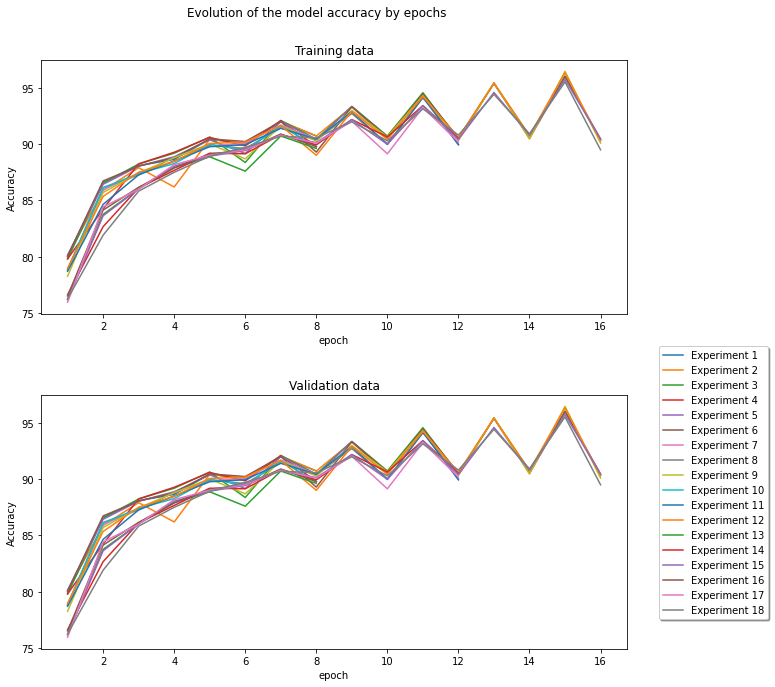

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
for combination in itertools.product(batch_size, token_size, epochs, max_norm):
    train_accuracy = valid_accuracy = []
    model, optimizer = get_model()
    print(f'Training cross-validation model for {combination[2]} epochs')
    t0 = time.time()
    with mlflow.start_run(run_name=str(run_index)) as run:
        for epoch in range(1, combination[2] + 1):
            mlflow.log_params({"batch_size": combination[0], "token_size": combination[1], "epochs": combination[2], "max_norm": combination[3]})
            acc_t = train(model, optimizer, train_data, combination[0], combination[1], combination[3], log=epoch==1)
            train_accuracy.append(acc_t)
            print(f'| epoch {epoch:03d} | train accuracy={acc_t:.1f}% ({time.time() - t0:.0f}s)')
            acc_v = validate(model, val_data, combination[0], combination[1])
            valid_accuracy.append(acc_v)
            print(f'| epoch {epoch:03d} | valid accuracy={acc_v:.1f}%') 
        mlflow.log_metric("Training Accuracy", acc_t)
        mlflow.log_metric("Validation Accuracy", acc_v)        
        run_id = run.info.run_uuid
        experiment_id = run.info.experiment_id
        mlflow.end_run()
        print_model_information(model, run_id) 
        ax1.plot(range(1, len(train_accuracy)+1), train_accuracy, label = "Experiment " + str(run_index))
        ax2.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
        ax1.set(xlabel='epoch', ylabel='Accuracy')
        ax2.set(xlabel='epoch', ylabel='Accuracy')
    run_index += 1

configure_plot(fig, ax1, ax2)

In [25]:
tracker.stop()

[codecarbon INFO @ 19:10:12] Energy consumed for RAM : 0.035335 kWh. RAM Power : 5.861831188201904 W
[codecarbon INFO @ 19:10:12] Energy consumed for all GPUs : 0.621606 kWh. All GPUs Power : 39.61 W
[codecarbon INFO @ 19:10:12] Energy consumed for all CPUs : 0.256431 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:10:12] 0.913371 kWh of electricity used since the begining.


0.2904521261245064

This is the output of the codecarbon analysis.

The visuals above show the evolution of the accuracy of the model through the epochs, for each experiment.

The model has been trained correctly. We will obtain the definitive hyperparameters by checking MLFLOW (in DagsHub).

The end.